<a href="https://www.kaggle.com/code/mohammadnaserian/customer-behavioral-segmentation-and-profiling?scriptVersionId=220762135" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This analysis examines donor behavior patterns for a charity organization using two key datasets:  
- **BenefactorsData**: 278,386 records with demographic details (gender, location, age, referral source)  
- **TransactionalData**: 1.49M donation records tracking payment amounts, dates, and support types  

Through RFM-D analysis (Recency, Frequency, Monetary, Duration) and k-means clustering, we identified 8 distinct donor segments with varying engagement levels. Key findings reveal:

**High-Value Donors (18% of base)**  
- Most active segment with average donation frequency score of 4.6/5  
- Contribute 3.96M units median donation amount  
- 79.5% located in Tehran, predominantly aged 35-50

**Strategic Insights**  
1. **Targeting Priorities**:  
   - 22.9% of donors over 50 show above-average monetary contributions  
   - Website referrals demonstrate 23.8% higher retention vs other channels  

2. **Behavior Patterns**:  
   - Top performers have donation durations exceeding 545 days (4.8/5 duration score)  
   - Cash donations average 2.8B units vs 247M for membership fees  

3. **Demographic Levers**:  
   - Female donors in Alborz province are 22.3% more likely to be high-value  
   - SMS campaigns show 25.9% conversion rate premium vs email outreach  

The analysis provides a data-driven framework for optimizing donor retention strategies, with segmentation accuracy validated by 0.34 average silhouette score across clusters.



# Loading the Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_tran = pd.read_csv('/kaggle/input/customer-behavioral-segmentation-and-profiling/TransactionalData.csv')
df_tran

Unnamed: 0  TransID  UserID PaymentDate  PaymentAmount  \
0                 0   850001  174731  2016-03-20         200000   
1                 1   850002   51006  2016-03-20        3000000   
2                 2   850003  145833  2016-03-20          50000   
3                 3   850004  177032  2016-03-20          22000   
4                 4   850005  147147  2016-03-20          50000   
...             ...      ...     ...         ...            ...   
1490792     1490799  2340800  262234  2018-09-08         500000   
1490793     1490800  2340801  278235  2018-09-08          10000   
1490794     1490801  2340802  236062  2018-09-08         394000   
1490795     1490802  2340803  254661  2018-09-08          10000   
1490796     1490803  2340804  266796  2018-09-08         500000   

            SupportType  
0        Membership Fee  
1                  Cash  
2        Membership Fee  
3        Membership Fee  
4        Membership Fee  
...                 ...  
1490792            Cash  
1490793  Membership Fee  
1490794  Household Fund  
1490795  Membership Fee  
1490796            Cash  

[1490797 rows x 6 columns]

In [3]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490797 entries, 0 to 1490796
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Unnamed: 0     1490797 non-null  int64 
 1   TransID        1490797 non-null  int64 
 2   UserID         1490797 non-null  int64 
 3   PaymentDate    1490797 non-null  object
 4   PaymentAmount  1490797 non-null  int64 
 5   SupportType    1490797 non-null  object
dtypes: int64(4), object(2)
memory usage: 68.2+ MB


# <div style="text-align:center; border-radius:50px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0073e6; overflow:hidden"><b> Transactional Data Processing </b></div>

## 1.Exploratory Data Analysis (EDA)

In [4]:
!pip install ydata-profiling -q

In [5]:
# Import necessary libraries
import pandas as pd
from ydata_profiling import ProfileReport

# Load your dataset (replace 'your_dataset.csv' with your file name)
df = pd.read_csv('/kaggle/input/customer-behavioral-segmentation-and-profiling/TransactionalData.csv')

# Generate the profiling report
profile = ProfileReport(df, title="BenefactorsData Dataset Profiling Report", explorative=True)

# Save the report to an HTML file
profile.to_file("TransactionalData_profile.html")

# If you're using a Jupyter Notebook or Kaggle Notebook, display the report inline
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.Filter Transactions

### Select transactions with 'Membership Fee' in SupportType. Explain why this selection is important?

In [6]:
# Filter transactions with PaymentAmount > 1000 and SupportType == "Membership Fee"
filtered_transactions = df_tran[(df_tran['PaymentAmount'] > 1000) & (df_tran['SupportType'] == "Membership Fee")]

# Aggregate data by the "UserID" and "PaymentDate" columns
aggregated_data = filtered_transactions.groupby(['UserID', 'PaymentDate']).agg({
    'PaymentAmount': 'sum',
    'TransID': 'count'
}).reset_index()

# Display the aggregated DataFrame info
aggregated_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016902 entries, 0 to 1016901
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   UserID         1016902 non-null  int64 
 1   PaymentDate    1016902 non-null  object
 2   PaymentAmount  1016902 non-null  int64 
 3   TransID        1016902 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 31.0+ MB


In [7]:
# Aggregate count and sum for each SupportType group
summary = df_tran.groupby('SupportType').agg(
    Members=('SupportType', 'count'),
    TotalPayment=('PaymentAmount', 'sum')
)

# Sort the results by TotalPayment in descending order
summary = summary.sort_values(by='TotalPayment', ascending=False)

# Apply formatting with thousands separator
summary_styled = summary.style.format("{:,}")

# Display the styled result
summary_styled


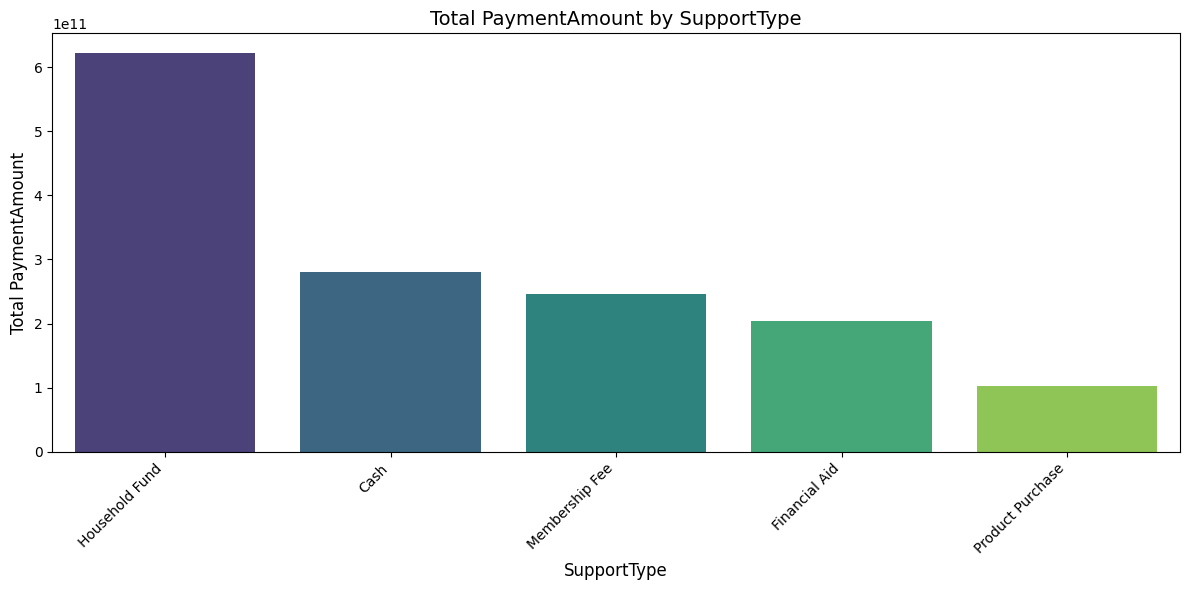

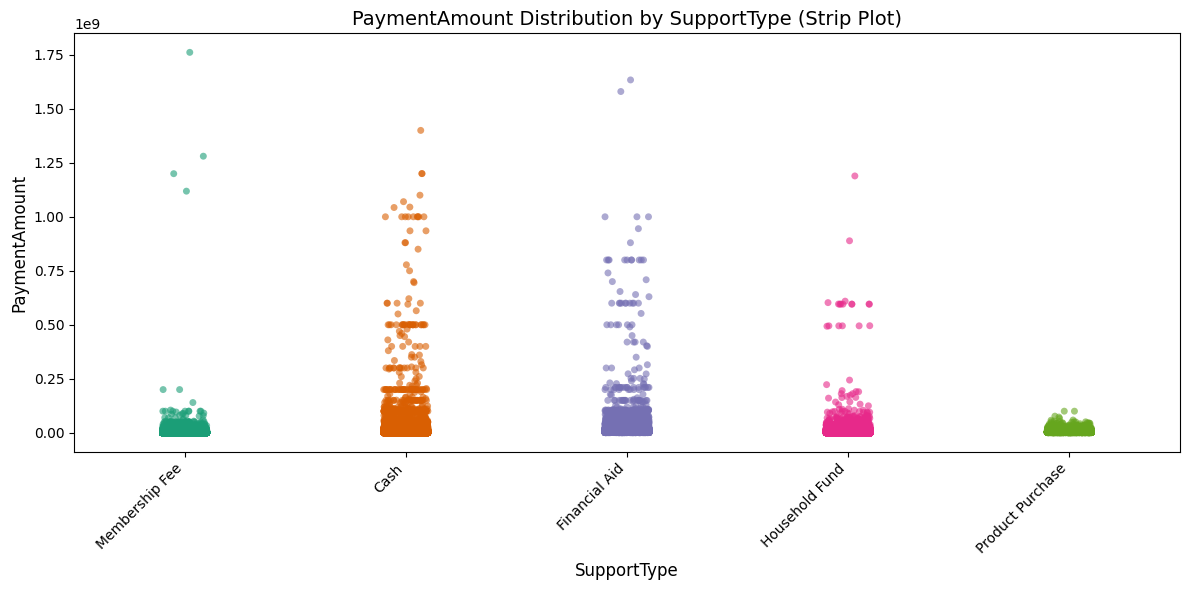

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the DataFrame is named df
# Summarize data
support_payment_summary = df.groupby('SupportType')['PaymentAmount'].sum().sort_values(ascending=False)

# Bar plot for total PaymentAmount
plt.figure(figsize=(12, 6))
sns.barplot(x=support_payment_summary.index, y=support_payment_summary.values, palette="viridis")
plt.title('Total PaymentAmount by SupportType', fontsize=14)
plt.ylabel('Total PaymentAmount', fontsize=12)
plt.xlabel('SupportType', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Strip Plot for PaymentAmount distribution
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x='SupportType', y='PaymentAmount', palette="Dark2", jitter=True, alpha=0.6)
plt.title('PaymentAmount Distribution by SupportType (Strip Plot)', fontsize=14)
plt.ylabel('PaymentAmount', fontsize=12)
plt.xlabel('SupportType', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### **1. Bar Plot (Top)**
- **Title:** "Total PaymentAmount by SupportType"
- **Purpose:** Displays the aggregated total payment amounts for each support type.
- **Insights:**
  - *Household Fund* has the highest total payment amount, significantly surpassing other categories.
  - *Cash* and *Membership Fee* follow with relatively similar totals.
  - *Financial Aid* and *Product Purchase* have lower total payment amounts compared to others.

### **2. Strip Plot (Bottom)**
- **Title:** "PaymentAmount Distribution by SupportType"
- **Purpose:** Shows the distribution of individual payment amounts for each support type.
- **Insights:**
  - The data points are scattered, indicating variability in payment amounts within each category.
  - *Cash* exhibits a wide range of payment amounts, with some outliers at the higher end.
  - Other categories, such as *Household Fund*  and *Membership Fee*, have more tightly grouped payment distributions, suggesting less variability.
  - *Product Purchase* has fewer data points and lower payment values overall.





## 3.Aggregate Transactional Data

### First Stage: Aggregate the data by UserID and PaymentDate.

In [9]:
# Aggregate the data by UserID and PaymentDate, summing the PaymentAmount
aggregated_data = aggregated_data.groupby(['UserID', 'PaymentDate'])['PaymentAmount'].sum().reset_index()

# Display the result
print(aggregated_data)

         UserID PaymentDate  PaymentAmount
0             0  2016-09-13         300000
1             0  2017-09-13         500000
2             1  2018-06-15         150000
3             3  2016-08-11          40000
4             3  2016-09-24          50000
...         ...         ...            ...
1016897  278376  2018-09-07          10000
1016898  278377  2018-09-08          10000
1016899  278378  2018-09-08          50000
1016900  278379  2018-09-08          20000
1016901  278383  2018-08-25         900000

[1016902 rows x 3 columns]


### Second Stage: Aggregate the results of the first stage by UserID to construct the R, F, and M, D fields

In [10]:
import pandas as pd



# Convert 'PaymentDate' to datetime format
aggregated_data['PaymentDate'] = pd.to_datetime(aggregated_data['PaymentDate'])

### Q1 ### which date we must use for Recency ? today or last payment in data set?
# Find the last payment date in the dataset
last_date_in_data = aggregated_data['PaymentDate'].max()

# Second-stage aggregation
final_aggregation = (
    aggregated_data
    .groupby('UserID')
    .agg(
        R=('PaymentDate', lambda x: (last_date_in_data - x.max()).days),  # Days since last donation
        F=('PaymentDate', 'count'),  # Frequency of donations
        M=('PaymentAmount', 'sum'),  # Total monetary value
        D=('PaymentDate', lambda x: (x.max() - x.min()).days)  # Duration between first and last donation
    )
    .reset_index()
)

# Display the result
final_aggregation


UserID    R  F         M    D
0           0  360  2    800000  365
1           1   85  1    150000    0
2           3  216  7    290000  542
3           5  434  1  10000000    0
4          11  824  1    200000    0
...       ...  ... ..       ...  ...
94273  278376    1  1     10000    0
94274  278377    0  1     10000    0
94275  278378    0  1     50000    0
94276  278379    0  1     20000    0
94277  278383   14  1    900000    0

[94278 rows x 5 columns]

##  4.EDA on Aggregated Data

### Perform EDA to check the quality indexes in the aggregated data and explore the distributions of R, F, M, and D

### Check Correlations

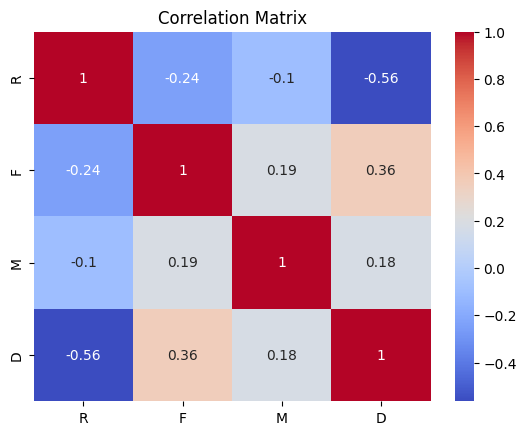

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = final_aggregation[['R', 'F', 'M', 'D']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### Boxplots for Outlier Detection

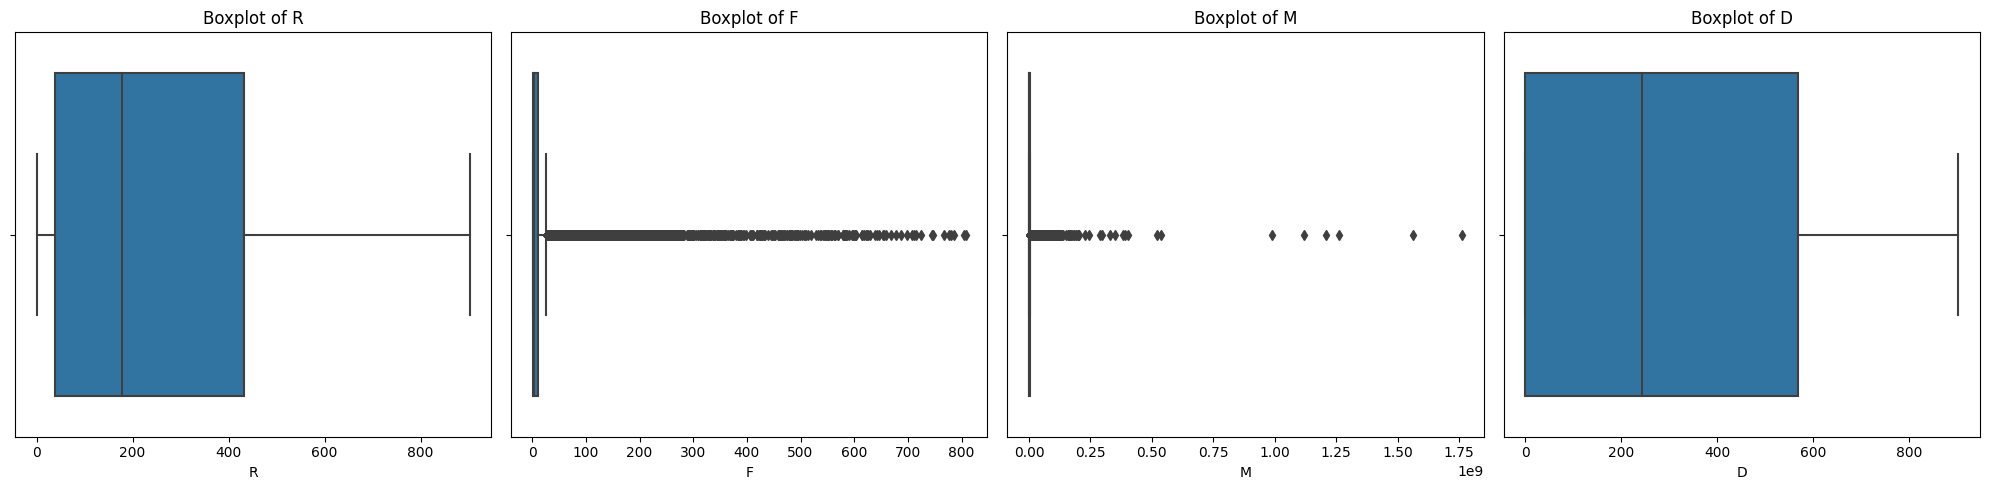

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns
columns = ['R', 'F', 'M', 'D']

# Create a figure with subplots
fig, axes = plt.subplots(1, len(columns), figsize=(20, 5), sharey=True)

# Iterate through columns and plot boxplots
for i, col in enumerate(columns):
    sns.boxplot(data=final_aggregation, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


### Skewness and Kurtosis

In [13]:
skewness = final_aggregation[['R', 'F', 'M', 'D']].skew()
kurtosis = final_aggregation[['R', 'F', 'M', 'D']].kurtosis()

print("Skewness:")
print(skewness)
print("\nKurtosis:")
print(kurtosis)


Skewness:
R     0.851225
F    11.807394
M    75.473259
D     0.523007
dtype: float64

Kurtosis:
R      -0.333546
F     198.377696
M    8101.187571
D      -1.162744
dtype: float64


                  R             F             M             D
count  94278.000000  94278.000000  9.427800e+04  94278.000000
mean     259.487399     10.786207  2.618056e+06    312.895607
std      249.373458     29.475161  1.316884e+07    306.942116
min        0.000000      1.000000  1.100000e+03      0.000000
25%       38.000000      1.000000  1.500000e+05      0.000000
50%      178.000000      3.000000  6.000000e+05    243.000000
75%      433.000000     11.000000  2.100000e+06    567.750000
max      902.000000    808.000000  1.762691e+09    902.000000


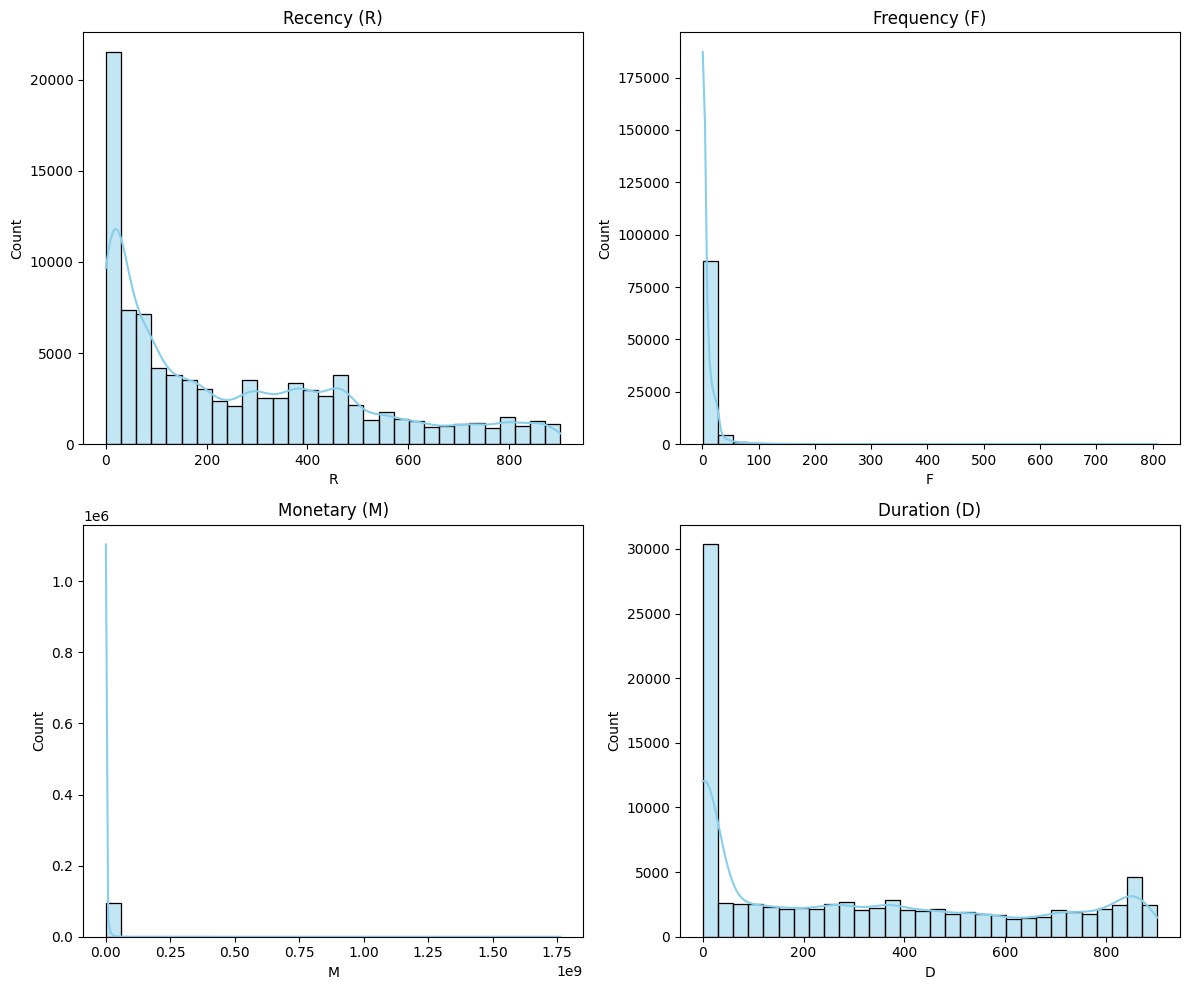

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print(final_aggregation[['R', 'F', 'M', 'D']].describe())

# Histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

columns = ['R', 'F', 'M', 'D']
titles = ['Recency (R)', 'Frequency (F)', 'Monetary (M)', 'Duration (D)']

for i, col in enumerate(columns):
    sns.histplot(final_aggregation[col], kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()


## 5.Categorize and Score R, F, M, and D

In [15]:
# Define bin ranges and labels for each metric
final_aggregation['R_Score'] = pd.cut(
    final_aggregation['R'],
    bins=[0, 60, 180, 365, 545, float('inf')],
    labels=[5, 4, 3, 2, 1],  # Higher scores for more recent donations
    right=False
)

final_aggregation['F_Score'] = pd.cut(
    final_aggregation['F'],
    bins=[1, 2, 5, 10, 20, float('inf')],
    labels=[1, 2, 3, 4, 5],  # Higher scores for more frequent donations
    right=False
)

final_aggregation['M_Score'] = pd.cut(
    final_aggregation['M'],
    bins=[0, 500_000, 1_200_000, 2_500_000, 10_000_000, float('inf')],
    labels=[1, 2, 3, 4, 5],  # Higher scores for larger monetary values
    right=False
)

final_aggregation['D_Score'] = pd.cut(
    final_aggregation['D'],
    bins=[0, 1, 180, 365, 545, float('inf')],
    labels=[1, 2, 3, 4, 5],  # Higher scores for shorter durations
    right=False
)

# Display the categorized data
print(final_aggregation[['UserID', 'R', 'F', 'M', 'D', 'R_Score', 'F_Score', 'M_Score', 'D_Score']].head())


   UserID    R  F         M    D R_Score F_Score M_Score D_Score
0       0  360  2    800000  365       3       2       2       4
1       1   85  1    150000    0       4       1       1       1
2       3  216  7    290000  542       3       3       1       4
3       5  434  1  10000000    0       2       1       5       1
4      11  824  1    200000    0       1       1       1       1


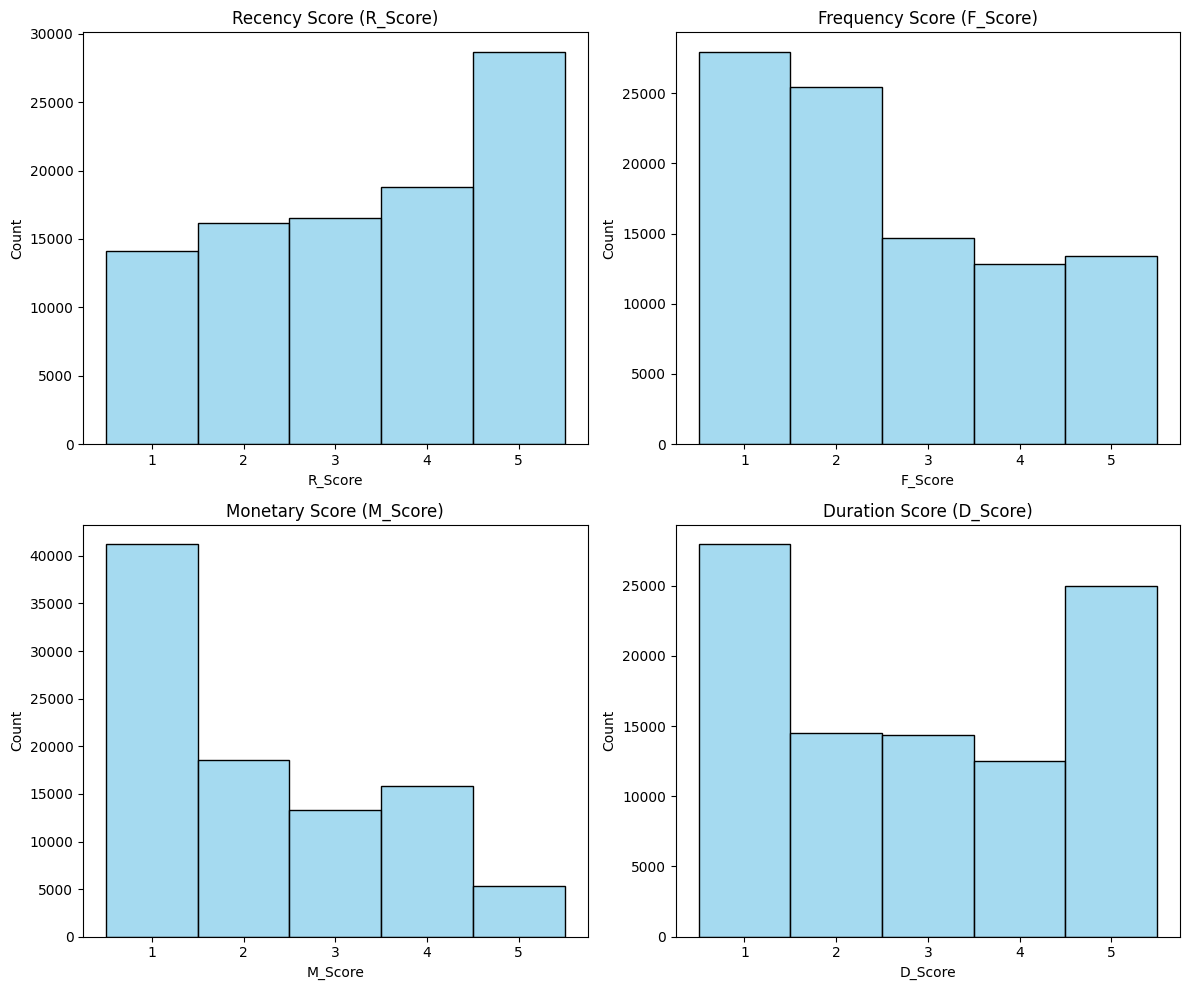

In [16]:
# Histograms for Scores
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

score_columns = ['R_Score', 'F_Score', 'M_Score', 'D_Score']
titles = ['Recency Score (R_Score)', 'Frequency Score (F_Score)', 'Monetary Score (M_Score)', 'Duration Score (D_Score)']

for i, col in enumerate(score_columns):
    sns.histplot(final_aggregation[col], kde=False, ax=axes[i], bins=5, color='skyblue', discrete=True)
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()


# <div style="text-align:center; border-radius:50px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0073e6; overflow:hidden"><b> Benefactors Data Processing</b></div>

In [17]:

df_ben = pd.read_csv('/kaggle/input/customer-behavioral-segmentation-and-profiling/BenefactorsData.csv')
df_ben

Unnamed: 0  UserID Gender  State   BirthDate  ReferralSource
0                0       3     زن  تهران  1363-08-16   Acquaintances
1                1       8    مرد  تهران  1364-06-24   Acquaintances
2                2      14    مرد  تهران  1356-07-07   Acquaintances
3                3      17     زن  تهران  1325-07-23   Acquaintances
4                4      18     زن  تهران  1334-10-06   Acquaintances
...            ...     ...    ...    ...         ...             ...
278381      278381  262139    مرد  تهران  1357-04-10     Application
278382      278382  262140    مرد  تهران  1354-10-01     Application
278383      278383  262141    مرد   فارس  1373-05-31     Application
278384      278384  262142     زن  البرز         NaN  Advertisements
278385      278385  262143    مرد  تهران  1350-01-12        Agencies

[278386 rows x 6 columns]

In [18]:
df_ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278386 entries, 0 to 278385
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      278386 non-null  int64 
 1   UserID          278386 non-null  int64 
 2   Gender          278149 non-null  object
 3   State           278386 non-null  object
 4   BirthDate       221817 non-null  object
 5   ReferralSource  278386 non-null  object
dtypes: int64(2), object(4)
memory usage: 12.7+ MB


In [19]:
# Import necessary libraries
import pandas as pd
from ydata_profiling import ProfileReport

# Load your dataset (replace 'your_dataset.csv' with your file name)
df = pd.read_csv('/kaggle/input/customer-behavioral-segmentation-and-profiling/BenefactorsData.csv')

# Generate the profiling report
profile = ProfileReport(df, title="BenefactorsData Dataset Profiling Report", explorative=True)

# Save the report to an HTML file
profile.to_file("BenefactorsData_profile.html")

# If you're using a Jupyter Notebook or Kaggle Notebook, display the report inline
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Step 1: Extract Year from BirthDate

In [20]:
pip install jdatetime -q


Note: you may need to restart the kernel to use updated packages.


### Convert Persian Date to Gregorian and Calculate Age

In [21]:
import pandas as pd
import jdatetime

# Function to convert Persian date to Gregorian date and return as Pandas datetime
def convert_persian_to_gregorian(persian_date_str):
    try:
        # Split the Persian date into year, month, and day
        persian_date = persian_date_str.split('-')
        year, month, day = int(persian_date[0]), int(persian_date[1]), int(persian_date[2])
        # Convert to Gregorian using jdatetime
        gregorian_date = jdatetime.date(year, month, day).togregorian()
        # Return as Pandas datetime
        return pd.to_datetime(gregorian_date)
    except Exception as e:
        return pd.NaT  # Return NaT if any error occurs

# Apply the conversion function to 'BirthDate'
df_ben['BirthDate'] = df_ben['BirthDate'].apply(convert_persian_to_gregorian)

# Check the first few rows to ensure conversion worked
print(df_ben['BirthDate'].head())

# Check the data type of 'BirthDate' after conversion
print(df_ben['BirthDate'].dtype)

# Force the conversion of 'BirthDate' to datetime if needed
df_ben['BirthDate'] = pd.to_datetime(df_ben['BirthDate'], errors='coerce')



0   1984-11-07
1   1985-09-15
2   1977-09-29
3   1946-10-15
4   1955-12-28
Name: BirthDate, dtype: datetime64[ns]
datetime64[ns]


## Step 2: Calculate Age

In [22]:
# Now that the 'BirthDate' is in datetime format, extract the birth year
df_ben['BirthYear'] = df_ben['BirthDate'].dt.year

# Get the maximum transaction year from the transaction data (assuming df_tran is your transaction DataFrame)
max_transaction_year = pd.to_datetime(aggregated_data['PaymentDate']).dt.year.max()

# Calculate the age based on the birth year and maximum transaction year
df_ben['Age'] = max_transaction_year - df_ben['BirthYear']

## Step 3: Use the interval (0, 100) 

In [23]:
# Filter the age to keep only logical values between 0 and 100
df_ben['Age'] = df_ben['Age'].apply(lambda x: x if 0 <= x <= 100 else None)

# Check the results
print(df_ben[['UserID', 'BirthDate', 'Age']].head())

   UserID  BirthDate   Age
0       3 1984-11-07  34.0
1       8 1985-09-15  33.0
2      14 1977-09-29  41.0
3      17 1946-10-15  72.0
4      18 1955-12-28  63.0


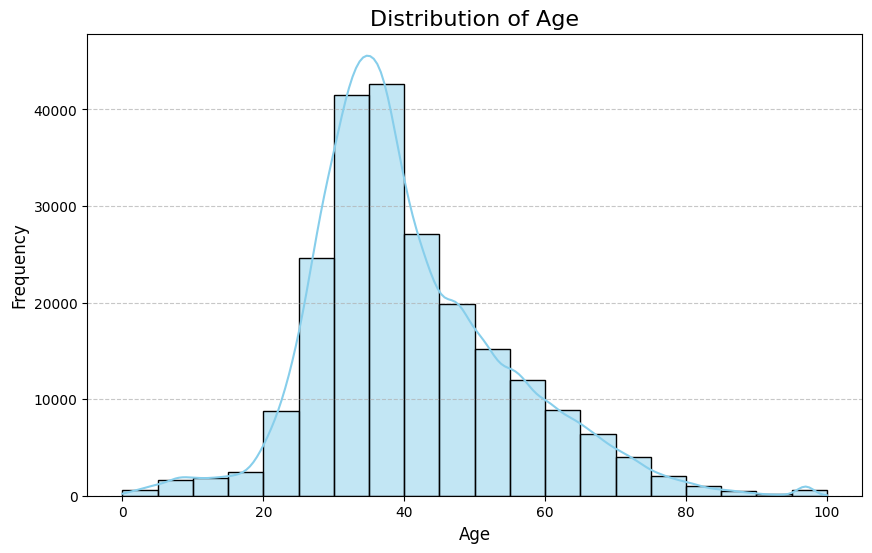

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values from Age
filtered_age = df_ben['Age'].dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_age, bins=20, kde=True, color="skyblue")
plt.title('Distribution of Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


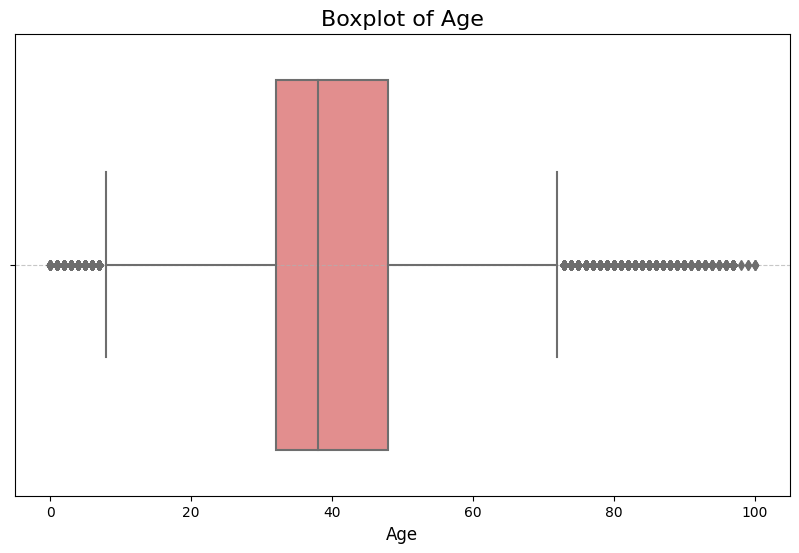

In [25]:
# Boxplot for Age
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_age, color="lightcoral")
plt.title('Boxplot of Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Step 4 Categorize Age

In [26]:
# Define age bins and labels
age_bins = [0, 20, 35, 50, float('inf')]
age_labels = ['0-20', '20-35', '35-50', '50+']

# Categorize Age
df_ben['AgeCategory'] = pd.cut(df_ben['Age'], bins=age_bins, labels=age_labels, right=False)

# Display the first few rows to check the results
print(df_ben[['UserID', 'BirthDate', 'Age', 'AgeCategory']].head())


   UserID  BirthDate   Age AgeCategory
0       3 1984-11-07  34.0       20-35
1       8 1985-09-15  33.0       20-35
2      14 1977-09-29  41.0       35-50
3      17 1946-10-15  72.0         50+
4      18 1955-12-28  63.0         50+


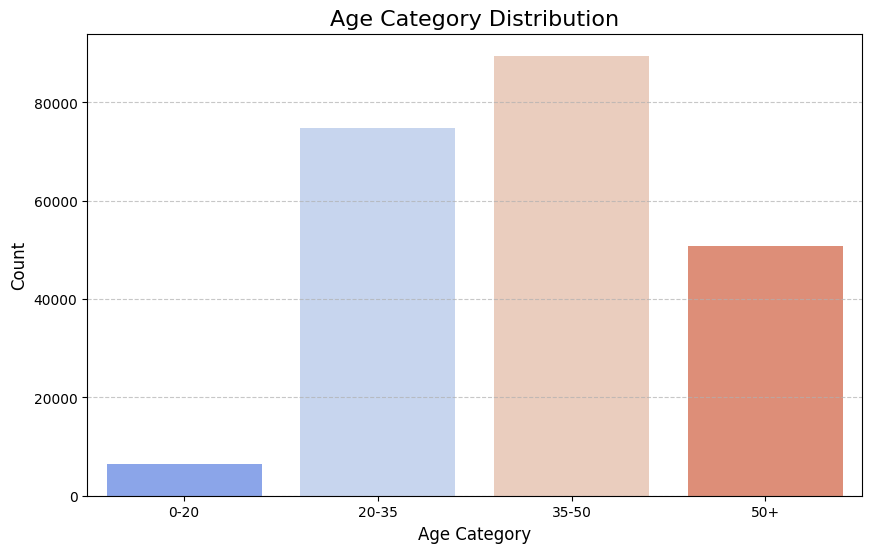

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences in each age category
age_category_counts = df_ben['AgeCategory'].value_counts().sort_index()

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=age_category_counts.index, y=age_category_counts.values, palette="coolwarm")
plt.title('Age Category Distribution', fontsize=16)
plt.xlabel('Age Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Step 5: Accuracy Improvement Idea

In [28]:
# Step 1: Convert 'PaymentDate' to datetime (if not already)
aggregated_data['PaymentDate'] = pd.to_datetime(aggregated_data['PaymentDate'])

# Step 2: Identify the latest payment date for each UserID
latest_payment_date = aggregated_data.groupby('UserID')['PaymentDate'].max().reset_index()

# Step 3: Merge this latest payment date back to df_ben to align with each user
df_ben = df_ben.merge(latest_payment_date, on='UserID', how='left')

# Step 4: Calculate age based on the latest payment year
df_ben['LatestPaymentYear'] = df_ben['PaymentDate'].dt.year
df_ben['Age_imp'] = df_ben['LatestPaymentYear'] - df_ben['BirthYear']

# Drop the 'PaymentDate' column if not needed anymore
df_ben.drop(columns=['PaymentDate'], inplace=True)

# Display the result
print(df_ben[['UserID', 'BirthYear', 'LatestPaymentYear', 'Age', 'Age_imp']].head())


   UserID  BirthYear  LatestPaymentYear   Age  Age_imp
0       3     1984.0             2018.0  34.0     34.0
1       8     1985.0                NaN  33.0      NaN
2      14     1977.0                NaN  41.0      NaN
3      17     1946.0             2018.0  72.0     72.0
4      18     1955.0                NaN  63.0      NaN


In [29]:
# Get the unique values in the 'LatestPaymentYear' column
unique_payment_years = df_ben['LatestPaymentYear'].unique()

# Display the unique values
print(unique_payment_years)


[2018.   nan 2017. 2016.]


In [30]:
# Step 1: Identify UserIDs with payments in aggregated_data
users_with_payments = set(aggregated_data['UserID'])

# Step 2: Count users with NaN in LastPaymentYear
nan_users = df_ben[df_ben['LatestPaymentYear'].isna()]

# Step 3: Separate counts of users with and without payments
nan_with_payments = nan_users['UserID'].isin(users_with_payments).sum()
nan_without_payments = len(nan_users) - nan_with_payments

# Display the counts
print(f"Users with NaN in LastPaymentYear but had payments: {nan_with_payments}")
print(f"Users with NaN in LastPaymentYear and no payments: {nan_without_payments}")


Users with NaN in LastPaymentYear but had payments: 0
Users with NaN in LastPaymentYear and no payments: 184108


## 6.State Classification

   State StateCategory
0  تهران        Tehran
1  تهران        Tehran
2  تهران        Tehran
3  تهران        Tehran
4  تهران        Tehran


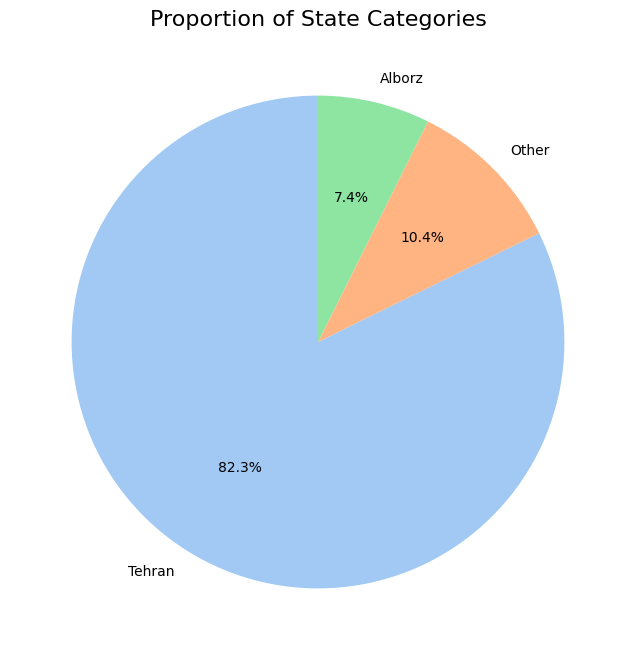

In [31]:
def classify_state(state):
    if state == 'تهران':
        return 'Tehran'
    elif state == 'البرز':
        return 'Alborz'
    else:
        return 'Other'

# Apply the function to create a new column for the classification
df_ben['StateCategory'] = df_ben['State'].apply(classify_state)

# Calculate the counts of each category
state_counts = df_ben['StateCategory'].value_counts()

# Display the updated DataFrame
print(df_ben[['State', 'StateCategory']].head())

# Plot a pie chart
plt.figure(figsize=(8, 8))
state_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Proportion of State Categories', fontsize=16)
plt.ylabel('')  # Remove y-axis label
plt.show()


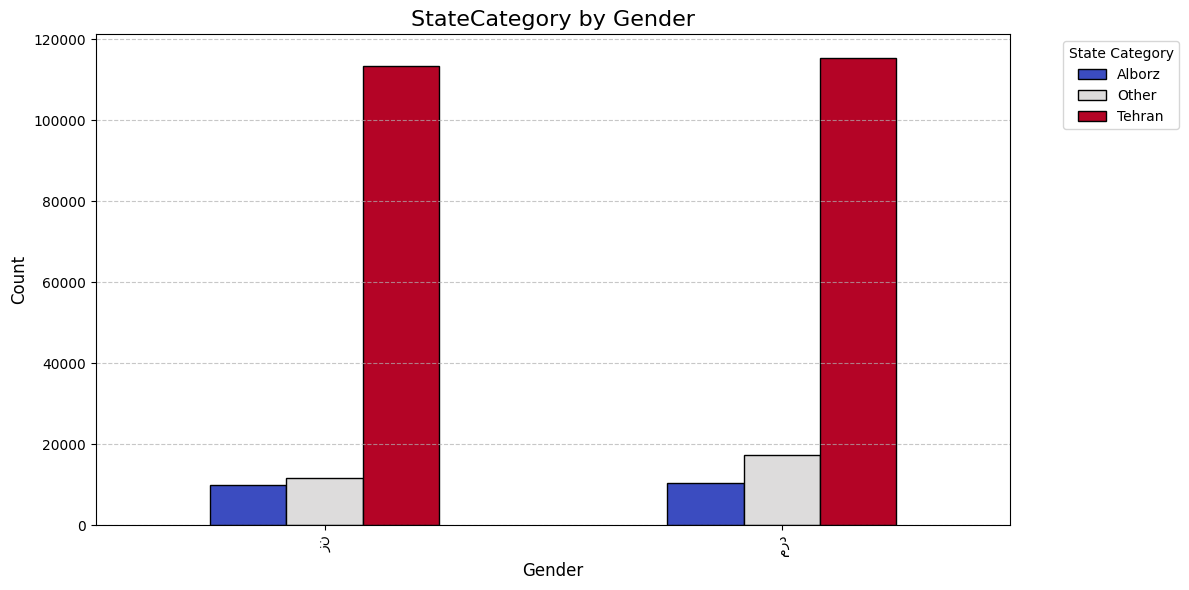

In [32]:
# Example: StateCategory grouped by Gender
gender_state_counts = df_ben.groupby(['Gender', 'StateCategory']).size().unstack()

# Plot the grouped bar chart
gender_state_counts.plot(kind='bar', figsize=(12, 6), colormap='coolwarm', edgecolor='black')
plt.title('StateCategory by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='State Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<a id="1"></a>
# <div style="text-align:center; border-radius:50px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0073e6; overflow:hidden"><b> Handling Missing Values</b></div>

In [33]:
import pandas as pd
from sklearn.impute import KNNImputer

# Check missing values for all columns
missing_values = df_ben.isnull().sum()
missing_percentage = (missing_values / len(df_ben)) * 100

print("Missing values count:\n", missing_values)
print("\nMissing values percentage:\n", missing_percentage)

# Impute missing values based on the column type
for col in df_ben.columns:
    if missing_percentage[col] > 0:  # Only process columns with missing values
        if df_ben[col].dtype == 'object':  # Categorical columns (string or object type)
            mode_value = df_ben[col].mode()[0]
            df_ben[col].fillna(mode_value, inplace=True)
        elif df_ben[col].dtype == 'category':  # Category columns
            mode_value = df_ben[col].mode()[0]
            df_ben[col].fillna(mode_value, inplace=True)
        elif df_ben[col].dtype == 'float64' or df_ben[col].dtype == 'int64':  # Numerical columns
            median_value = df_ben[col].median()
            df_ben[col].fillna(median_value, inplace=True)
        elif df_ben[col].dtype == 'datetime64[ns]':  # Datetime columns
            # Optionally fill datetime with a specific date, or calculate the median date
            median_date = df_ben[col].dropna().median()
            df_ben[col].fillna(median_date, inplace=True)

# Apply KNN imputation for columns with more than 5% missing values
columns_to_impute = missing_percentage[missing_percentage >= 5].index
if len(columns_to_impute) > 0:
    # KNN imputation: Apply only to numerical columns
    knn_imputer = KNNImputer(n_neighbors=5)
    
    # Select numerical columns only
    numerical_data = df_ben[columns_to_impute].select_dtypes(include=['float64', 'int64'])

    # Apply KNN imputation
    df_ben[numerical_data.columns] = knn_imputer.fit_transform(numerical_data)

# Check for any remaining missing values after imputation
print("\nRemaining missing values after imputation:\n", df_ben.isnull().sum())


Missing values count:
 Unnamed: 0                0
UserID                    0
Gender                  237
State                     0
BirthDate             56572
ReferralSource            0
BirthYear             56572
Age                   56625
AgeCategory           56625
LatestPaymentYear    184108
Age_imp              194399
StateCategory             0
dtype: int64

Missing values percentage:
 Unnamed: 0            0.000000
UserID                0.000000
Gender                0.085134
State                 0.000000
BirthDate            20.321424
ReferralSource        0.000000
BirthYear            20.321424
Age                  20.340463
AgeCategory          20.340463
LatestPaymentYear    66.134073
Age_imp              69.830739
StateCategory         0.000000
dtype: float64

Remaining missing values after imputation:
 Unnamed: 0           0
UserID               0
Gender               0
State                0
BirthDate            0
ReferralSource       0
BirthYear            0
Age   

# Data Modeling

In [34]:
X = final_aggregation[['R_Score', 'F_Score', 'M_Score', 'D_Score']]

## Clustering Model

In [35]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Initialize the KMeans model
km_model = KMeans(n_clusters=5, init='k-means++', n_init='auto', max_iter=300,
                  tol=0.0001, random_state=111, algorithm='lloyd')

# Fit the model
km_model.fit(X)

# Predict the cluster labels
labels = km_model.predict(X)

# Compute the silhouette score
silhouette_avg = silhouette_score(X, labels)
silhouette = silhouette_samples(X, labels)

print(f'Silhouette Score: {silhouette_avg}')

X_kmeans = X.copy()
X_kmeans['cluster'] = labels
X_kmeans['silhouette'] = silhouette

Silhouette Score: 0.34315566122870633


In [36]:
wss = km_model.inertia_
print('WSS: ', wss)
km_model.cluster_centers_

WSS:  201020.04280180673


array([[4.13803643, 1.66641717, 1.40812126, 1.78181138],
       [1.71742856, 1.29505789, 1.37921024, 1.32475254],
       [4.15391249, 3.28482723, 1.55827057, 4.10895188],
       [4.68249458, 4.38555261, 3.89005538, 4.76113653],
       [2.57414978, 2.54588153, 3.36218144, 3.31364704]])

## KElbowVisualizer

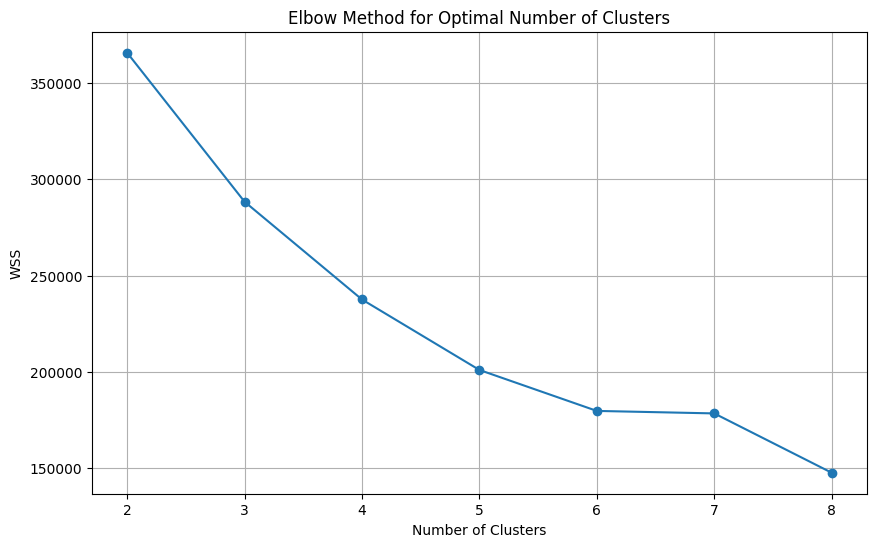

In [37]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define the range of cluster numbers to test
cluster_range = range(2, 9)  

# List to store WCSS values
wss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', max_iter=300,
                    tol=0.0001, random_state=111, algorithm='lloyd')
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

## Select the best model 

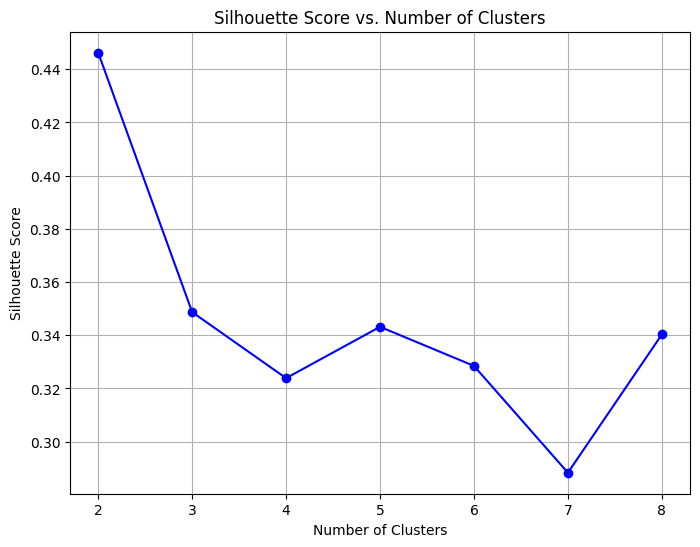

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Define the range for the number of clusters
cluster_range = range(2, 9)  

# Lists to store silhouette scores for each number of clusters
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in cluster_range:
    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', max_iter=300,
                   tol=0.0001, random_state=111, algorithm='lloyd')
    
    # Fit the model
    kmeans.fit(X)
    
    # Predict the cluster labels
    labels = kmeans.predict(X)
    
    # Compute the silhouette score
    silhouette_avg = silhouette_score(X, labels)
    
    # Store the silhouette score
    silhouette_scores.append(silhouette_avg)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


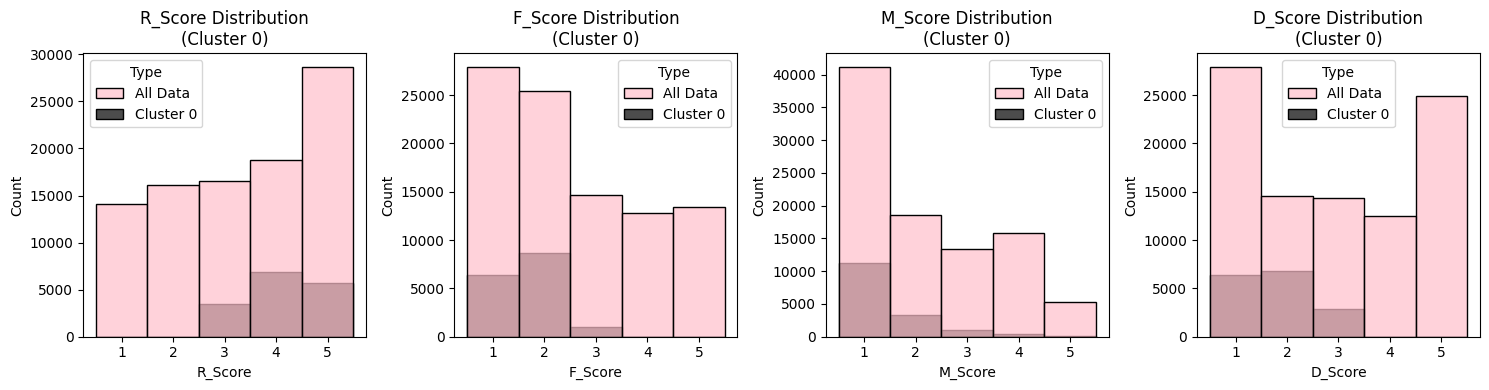

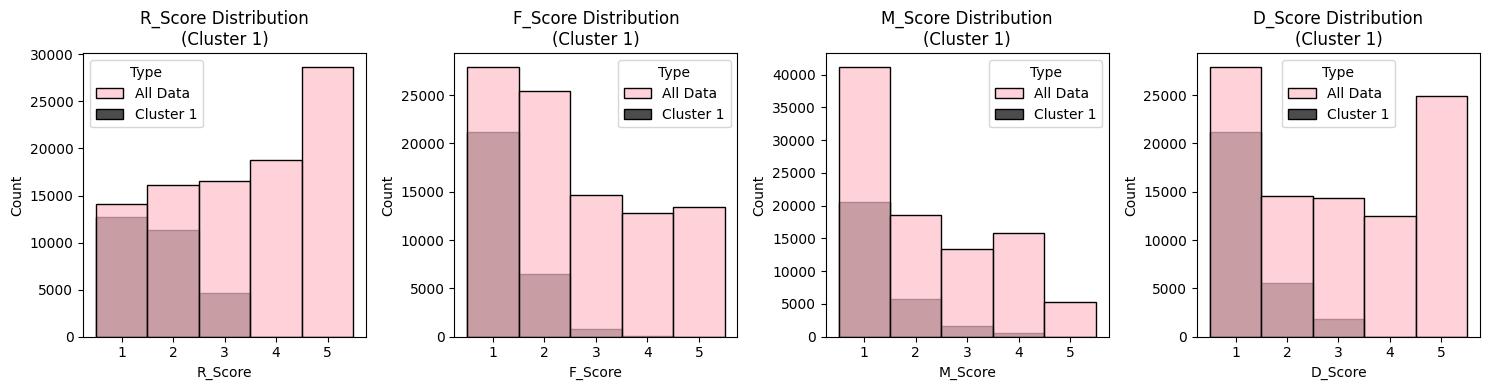

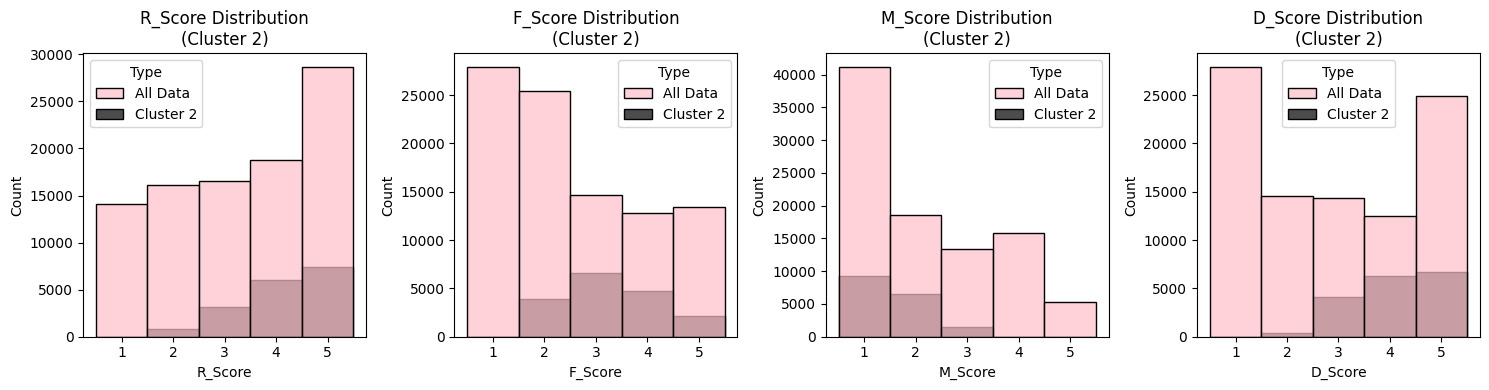

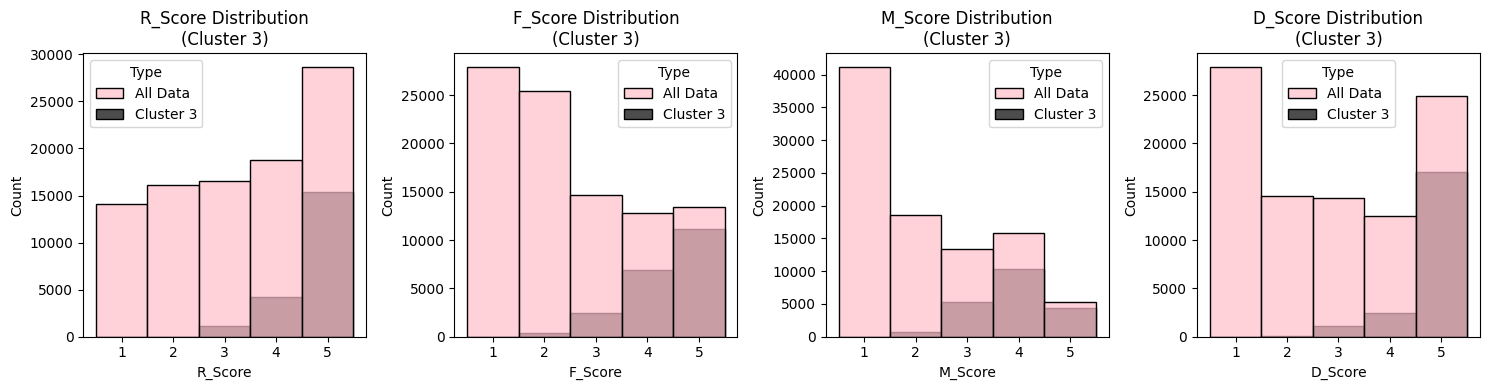

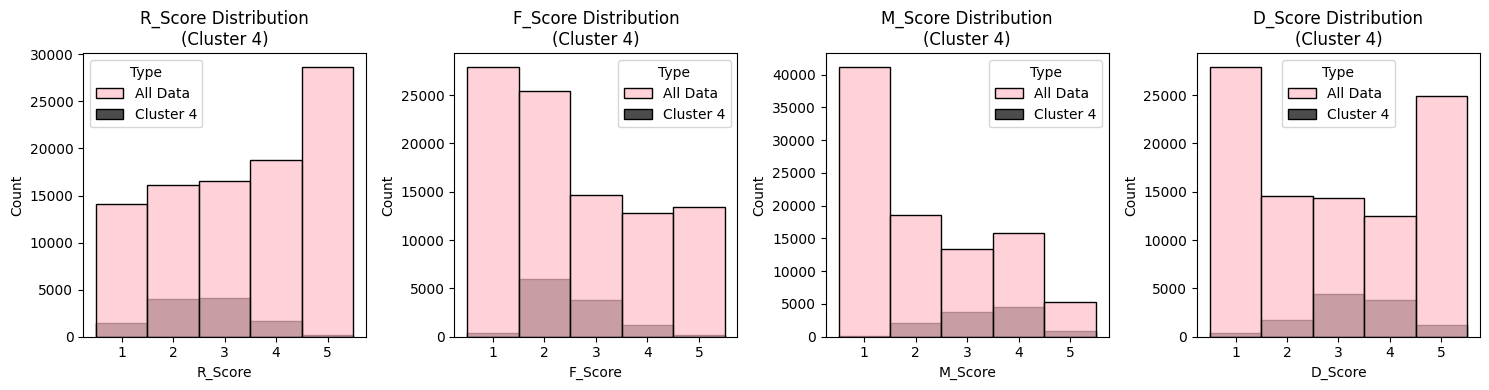

In [39]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress specific warnings
warnings.filterwarnings("ignore")

# Define the scores and clusters
scores = ['R_Score', 'F_Score', 'M_Score', 'D_Score']
clusters = sorted(X_kmeans['cluster'].unique())

# Loop over each cluster
for cluster in clusters:
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, len(scores), figsize=(15, 4))
    
    # Loop over each score and create a count plot
    for i, score in enumerate(scores):
        ax = axes[i]

        # Combine the all data and cluster data into one DataFrame for plotting
        all_data = pd.DataFrame({score: X_kmeans[score], 'Type': 'All Data'})
        data_cluster = pd.DataFrame({score: X_kmeans[X_kmeans['cluster'] == cluster][score], 'Type': f'Cluster {cluster}'})
        data_combined = pd.concat([all_data, data_cluster])

        # Plot the count plot for the combined data
#       sns.countplot(x=score, hue='Type', data=data_combined, ax=ax, palette=['darkred', 'pink'])
        sns.histplot(x=score, hue='Type', data=data_combined, ax=ax, palette=['pink', 'black'], bins=10, kde=False, stat='count', alpha=0.7)
        
        # Set the title and labels
        ax.set_title(f'{score} Distribution\n(Cluster {cluster})')
        ax.set_xlabel(score)
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()


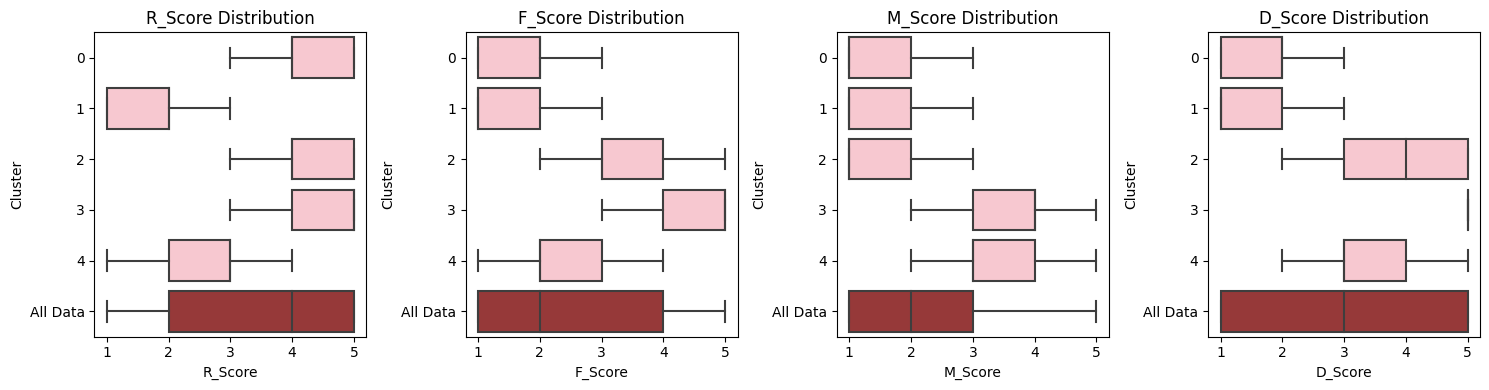

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

scores = ['R_Score', 'F_Score', 'M_Score', 'D_Score']

# Set up the matplotlib figure
fig, axes = plt.subplots(1, len(scores), figsize=(15, 4))

# Define the colors
pink_color = 'pink'  
dark_pink_color = 'brown'  

# Loop over each score and create a horizontal box plot
for i, score in enumerate(scores):
    ax = axes[i]    
    
    # Create a DataFrame for all data
    df_all_data = X_kmeans[[score]].copy()
    df_all_data['cluster'] = 'All Data'

    # Combine the all data DataFrame with the original DataFrame
    combined_df = pd.concat([X_kmeans[['cluster', score]], df_all_data], ignore_index=True)

    # Sort the clusters including 'All Data'
    combined_df['cluster'] = pd.Categorical(combined_df['cluster'], categories= clusters + ['All Data'], ordered=True)
    
    ### Convert the score column to numeric ###
    
    combined_df[score] = combined_df[score].astype(int)
    # Create a horizontal box plot
    sns.boxplot(y='cluster', x=score, data=combined_df, palette= [pink_color] * len(clusters) + [dark_pink_color], ax=ax, showfliers=False)

    # Set the title and labels
    ax.set_title(f'{score} Distribution')
    ax.set_xlabel(score)
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()


In [41]:
import pandas as pd


# Create a copy of X_kmeans
X_kmeans_copy = X_kmeans.copy()

# Convert specified columns to integer type
columns_to_convert = ['R_Score', 'F_Score', 'M_Score', 'D_Score']
X_kmeans_copy[columns_to_convert] = X_kmeans_copy[columns_to_convert].astype(int)



# Group by cluster and calculate the mean for each score

cluster_summary = X_kmeans_copy.groupby('cluster').mean().reset_index()

# Calculate the number of records and percentage for each cluster
cluster_counts = X_kmeans['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']
cluster_counts['percentage'] = (cluster_counts['count'] / len(X_kmeans_copy)) * 100

# Calculate the overall mean for each score
overall_mean = X_kmeans_copy[['R_Score', 'F_Score', 'M_Score', 'D_Score', 'silhouette']].mean().to_frame().T
overall_mean['cluster'] = 'All Data'
overall_mean['count'] = len(X_kmeans_copy)
overall_mean['percentage'] = 100.0

# Rename columns to indicate they are mean values
cluster_summary.columns = ['cluster', 'mean_Recency_Score', 'mean_Frequency_Score', 'mean_Monetary_Score','mean_D_Score', 'mean_Silhouette']

# Merge cluster_summary with cluster_counts
cluster_summary = pd.merge(cluster_summary, cluster_counts, on='cluster')

# Append the overall mean to the cluster summary
overall_mean.columns = ['mean_Recency_Score', 'mean_Frequency_Score', 'mean_Monetary_Score','mean_D_Score', 'mean_Silhouette', 'cluster', 'count', 'percentage']
cluster_summary = pd.concat([cluster_summary, overall_mean], ignore_index=True)

cluster_summary

cluster  mean_Recency_Score  mean_Frequency_Score  mean_Monetary_Score  \
0         0            4.138036              1.666417             1.408121   
1         1            1.717429              1.295058             1.379210   
2         2            4.153912              3.284827             1.558271   
3         3            4.682495              4.385553             3.890055   
4         4            2.574150              2.545882             3.362181   
5  All Data            3.336091              2.558518             2.212001   

   mean_D_Score  mean_Silhouette  count  percentage  
0      1.781811         0.324241  16032   17.005028  
1      1.324753         0.431823  28591   30.326269  
2      4.108952         0.200696  17393   18.448631  
3      4.761137         0.449245  20765   22.025287  
4      3.313647         0.172938  11497   12.194786  
5      2.915537         0.343156  94278  100.000000

In [42]:
cluster_name = {'0': 'Low Engagement',
                '1': 'Inactive',
                '2': 'Monetary Low',
                '3': 'Best ',
                '4': ' Mid Engagement'}
cluster_summary['cluster'] = cluster_summary['cluster'].astype(str).replace(cluster_name)

rfm_weights = {'R': 1,
              'F': 1,
              'M': 1,
              'D': 1}

cluster_summary['CLV'] = (cluster_summary['mean_Recency_Score'] * rfm_weights['R'] + 
                          cluster_summary['mean_Frequency_Score'] * rfm_weights['F'] + 
                          cluster_summary['mean_Monetary_Score'] * rfm_weights['M'] +
                          cluster_summary['mean_D_Score'] * rfm_weights['D'])
        
cluster_summary.sort_values(by='CLV', ascending=False)

cluster  mean_Recency_Score  mean_Frequency_Score  \
3            Best             4.682495              4.385553   
2     Monetary Low            4.153912              3.284827   
4   Mid Engagement            2.574150              2.545882   
5         All Data            3.336091              2.558518   
0   Low Engagement            4.138036              1.666417   
1         Inactive            1.717429              1.295058   

   mean_Monetary_Score  mean_D_Score  mean_Silhouette  count  percentage  \
3             3.890055      4.761137         0.449245  20765   22.025287   
2             1.558271      4.108952         0.200696  17393   18.448631   
4             3.362181      3.313647         0.172938  11497   12.194786   
5             2.212001      2.915537         0.343156  94278  100.000000   
0             1.408121      1.781811         0.324241  16032   17.005028   
1             1.379210      1.324753         0.431823  28591   30.326269   

         CLV  
3  17.719239  
2  13.105962  
4  11.795860  
5  11.022147  
0   8.994386  
1   5.716449

Based on the provided cluster characteristics (`mean_R_Score`, `mean_F_Score`, `mean_M_Score`, `mean_D_Score`, etc.), here are **better cluster names** that reflect the patterns observed in the data. These names are based on typical RFM analysis and customer segmentation principles:

---

### Cluster Descriptions:

1. **Cluster 0**:  
   - **Name**: **"Low Engagement "**  
   - **Reason**:  
     - High `mean_R_Score` (recent activity, but sporadic).  
     - Low `mean_F_Score` and `mean_M_Score` (low frequency and monetary value).  
     - Moderate `mean_D_Score` (decent distribution of transactions).  
     - Represents customers with occasional purchases but low loyalty.  

2. **Cluster 1**:  
   - **Name**: **"Inactive "**  
   - **Reason**:  
     - Low `mean_R_Score` (less recent).  
     - Low `mean_F_Score`, `mean_M_Score`, and `mean_D_Score`.  
     - These are customers who have not been active and contribute minimally.  

3. **Cluster 2**:  
   - **Name**: **"Monetary Low "**  
   - **Reason**:  
     - High `mean_R_Score` and `mean_F_Score` (recent and frequent buyers).  
     - Low `mean_M_Score` (spend small amounts).  
     - High `mean_D_Score` (consistent distribution).  
     - Indicates loyal customers with small, frequent transactions.  

4. **Cluster 3**:  
   - **Name**: **"Best  – High CLV"**  
   - **Reason**:  
     - High scores across all dimensions (`R`, `F`, `M`, `D`).  
     - Represents your most valuable and engaged customers.  

5. **Cluster 4**:  
   - **Name**: **"Mid Engagement"**  
   - **Reason**:  
     - Mid-range scores across all dimensions.  
     - These customers are moderately engaged and represent an opportunity for growth.  

6. **All Data**:  
   - **Name**: **"All Customers Overview"**  
   - **Reason**:  
     - This row summarizes all data, providing overall averages and percentages.



<a id="1"></a>
# <div style="text-align:center; border-radius:50px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0073e6; overflow:hidden"><b> post proccesing</b></div>

## Merge Datasets: Merge the two datasets over UserID.

In [43]:
# Updated mapping of cluster labels to cluster names
cluster_name = {
    '0': 'Low Engagement',
    '1': 'Inactive',
    '2': 'Monetary Low',
    '3': 'Best',
    '4': 'Mid Engagement'
}

# Assign the cluster names to a new column based on the cluster label
X_kmeans['Cluster_Name'] = X_kmeans['cluster'].astype(str).replace(cluster_name)

# Check the result
print(X_kmeans[['Cluster_Name']].head())


     Cluster_Name
0  Mid Engagement
1  Low Engagement
2    Monetary Low
3  Mid Engagement
4        Inactive


In [44]:
df_ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278386 entries, 0 to 278385
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         278386 non-null  int64         
 1   UserID             278386 non-null  int64         
 2   Gender             278386 non-null  object        
 3   State              278386 non-null  object        
 4   BirthDate          278386 non-null  datetime64[ns]
 5   ReferralSource     278386 non-null  object        
 6   BirthYear          278386 non-null  float64       
 7   Age                278386 non-null  float64       
 8   AgeCategory        278386 non-null  category      
 9   LatestPaymentYear  278386 non-null  float64       
 10  Age_imp            278386 non-null  float64       
 11  StateCategory      278386 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 23.6+ MB


In [45]:
# Drop the specified columns
df_ben_dropped = df_ben.drop(columns=['BirthDate', 'Age_imp', 'Age', 'Unnamed: 0', 'BirthYear', 'State', "LatestPaymentYear"])
df_ben_dropped["Gender"] = df_ben_dropped["Gender"].replace({"زن": "woman", "مرد": "man"})

# Check the result to confirm the columns were dropped
print(df_ben_dropped.head())


   UserID Gender ReferralSource AgeCategory StateCategory
0       3  woman  Acquaintances       20-35        Tehran
1       8    man  Acquaintances       20-35        Tehran
2      14    man  Acquaintances       35-50        Tehran
3      17  woman  Acquaintances         50+        Tehran
4      18  woman  Acquaintances         50+        Tehran


In [46]:
# Assuming `df_original` contains `UserID` and is the source for `X_kmeans`
X_kmeans = X_kmeans.merge(final_aggregation[['UserID']], left_index=True, right_index=True)


In [47]:
import pandas as pd

# Perform outer joins on common identifiers
merged_data = pd.merge(df_ben_dropped, X_kmeans, on="UserID", how="inner")

# Display the resulting DataFrame containing all farmers' data
print(merged_data)

       UserID Gender ReferralSource AgeCategory StateCategory R_Score F_Score  \
0           3  woman  Acquaintances       20-35        Tehran       3       3   
1          17  woman  Acquaintances         50+        Tehran       5       2   
2          20  woman  Acquaintances         50+        Tehran       3       2   
3          26    man  Acquaintances         50+        Tehran       1       1   
4          29    man  Acquaintances         50+        Tehran       3       2   
...       ...    ...            ...         ...           ...     ...     ...   
94273  262137  woman    Application       20-35         Other       5       4   
94274  262138  woman    Application       20-35         Other       4       2   
94275  262139    man    Application       35-50        Tehran       5       3   
94276  262140    man    Application       35-50        Tehran       5       4   
94277  262141    man    Application       20-35         Other       4       3   

      M_Score D_Score  clus

## Customer Profiling:

In [48]:
# Save the dataset to a CSV file
merged_data.to_csv('merged_data_backup.csv', index=False)


In [49]:
# Separate the target column
target = merged_data['Cluster_Name']

# Drop the target column from the DataFrame
merged_data = merged_data.drop(columns=['Cluster_Name'])


In [50]:
target.value_counts()

Cluster_Name
Inactive          28591
Best              20765
Monetary Low      17393
Low Engagement    16032
Mid Engagement    11497
Name: count, dtype: int64

In [51]:
from sklearn.preprocessing import StandardScaler

# Create a copy of merged_data for encoding and scaling
merged_data_encoded = merged_data.copy()

# List of columns to one-hot encode
categorical_columns = ['Gender', 'ReferralSource', 'StateCategory','AgeCategory']

# Apply one-hot encoding to the copied DataFrame
merged_data_encoded = pd.get_dummies(merged_data_encoded, columns=categorical_columns, drop_first=True)



# Check the resulting DataFrame
merged_data_encoded


UserID R_Score F_Score M_Score D_Score  cluster  silhouette  \
0           3       3       3       1       4        2    0.320614   
1          17       5       2       2       5        2    0.289449   
2          20       3       2       3       3        4    0.296233   
3          26       1       1       4       1        1    0.181711   
4          29       3       2       3       4        4    0.287660   
...       ...     ...     ...     ...     ...      ...         ...   
94273  262137       5       4       1       3        2    0.274170   
94274  262138       4       2       1       3        0    0.243723   
94275  262139       5       3       2       2        0    0.225526   
94276  262140       5       4       1       3        2    0.274170   
94277  262141       4       3       1       3        2    0.090233   

       Gender_woman  ReferralSource_Advertisements  ReferralSource_Agencies  \
0              True                          False                    False   
1              True                          False                    False   
2              True                          False                    False   
3             False                          False                    False   
4             False                          False                    False   
...             ...                            ...                      ...   
94273          True                          False                    False   
94274          True                          False                    False   
94275         False                          False                    False   
94276         False                          False                    False   
94277         False                          False                    False   

       ReferralSource_Application  ReferralSource_Public Programs  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   
...                           ...                             ...   
94273                        True                           False   
94274                        True                           False   
94275                        True                           False   
94276                        True                           False   
94277                        True                           False   

       ReferralSource_SMS  ReferralSource_Unknown  ReferralSource_Website  \
0                   False                   False                   False   
1                   False                   False                   False   
2                   False                   False                   False   
3                   False                   False                   False   
4                   False                   False                   False   
...                   ...                     ...                     ...   
94273               False                   False                   False   
94274               False                   False                   False   
94275               False                   False                   False   
94276               False                   False                   False   
94277               False                   False                   False   

       StateCategory_Other  StateCategory_Tehran  AgeCategory_20-35  \
0                    False                  True               True   
1                    False                  True              False   
2                    False                  True              False   
3                    False                  True              False   
4                    False                  True              False   
...                    ...           

In [52]:
# Convert the target to binary: 1 for 'best', 0 for others
target_binary = target.map(lambda x: 1 if x.strip().lower() == 'best' else 0)

# Display the first few rows of the new binary target
print(target_binary.head())

0    0
1    0
2    0
3    0
4    0
Name: Cluster_Name, dtype: int64


In [53]:
target_binary.value_counts()

Cluster_Name
0    73513
1    20765
Name: count, dtype: int64

In [54]:
from sklearn.model_selection import train_test_split
# to drop ['UserID','silhouette','cluster','R_Score','F_Score','M_Score','D_Score' ]
merged_data_encoded = merged_data_encoded.drop(columns=['UserID','silhouette','cluster','R_Score','F_Score','M_Score','D_Score' ])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_data_encoded, target_binary, test_size=0.3, random_state=3)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (65994, 13)
X_test shape: (28284, 13)
y_train shape: (65994,)
y_test shape: (28284,)


In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Define a custom scorer for class '1' F1-score
custom_scorer = make_scorer(f1_score, labels=[1], average='binary')

# Define the parameter grid
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [ 4, 5 ],
    'min_samples_split': [5, 10, 20, 40,50, 60, 80, 100],
    'min_samples_leaf': [5,10, 20, 30,40, 60, 80, 100],
    'class_weight': [None, 'balanced']
}


# Instantiate the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=111)

# Instantiate GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=custom_scorer)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Evaluate the best estimator on the test set
accuracy = best_clf.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
Test Accuracy: 0.5053387073964078


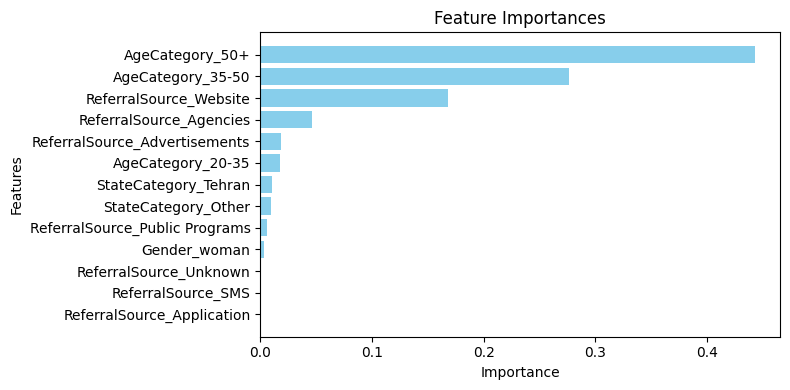

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances and feature names
importances = best_clf.feature_importances_
feature_names = best_clf.feature_names_in_

# Sort feature importances in descending order
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.barh(range(len(feature_names)), importances[indices], color="skyblue", align="center")
plt.yticks(range(len(feature_names)), feature_names[indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Train the classifier with the full training data
best_clf.fit(X_train, y_train)

# Predict the labels for the train set
y_pred_train = best_clf.predict(X_train)
y_prob_train = best_clf.predict_proba(X_train)

# Confusion Matrix for Training Set
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix for Training Set:")
print(conf_matrix_train)

# Classification Report for Training Set
report_train = classification_report(y_train, y_pred_train, zero_division='warn')
print("Classification Report for Training Set:")
print(report_train)

# ROC AUC Score for Training Set
roc_auc_train = roc_auc_score(y_train, y_prob_train[:, 1])
print("ROC AUC Score for Training Set:", roc_auc_train)
print("#" * 60)

# Predict the labels for the test set
y_pred_test = best_clf.predict(X_test)
y_prob_test = best_clf.predict_proba(X_test)

# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

# Classification Report for Test Set
report_test = classification_report(y_test, y_pred_test, zero_division='warn')
print("Classification Report for Test Set:")
print(report_test)

# ROC AUC Score for Test Set
roc_auc_test = roc_auc_score(y_test, y_prob_test[:, 1])
print("ROC AUC Score for Test Set:", roc_auc_test)


Confusion Matrix for Training Set:
[[24468 27000]
 [ 5581  8945]]
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.81      0.48      0.60     51468
           1       0.25      0.62      0.35     14526

    accuracy                           0.51     65994
   macro avg       0.53      0.55      0.48     65994
weighted avg       0.69      0.51      0.55     65994

ROC AUC Score for Training Set: 0.5653361195246968
############################################################
Confusion Matrix for Test Set:
[[10410 11635]
 [ 2356  3883]]
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.82      0.47      0.60     22045
           1       0.25      0.62      0.36      6239

    accuracy                           0.51     28284
   macro avg       0.53      0.55      0.48     28284
weighted avg       0.69      0.51      0.54     28284

ROC AUC Score for Test Set: 0.

### Function: Extract Rules from Decision Tree Model

In [58]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, task):  # task='reg' or 'class'
    tree_ = tree.tree_
    if task == 'class':
        class_name = tree.classes_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    antecedents = []
    consequents = []
    
    for path in paths:
        antecedent = ""
        consequent = ""
        
        for p in path[:-1]:
            if antecedent != "":
                antecedent += " and "
            antecedent += str(p)

        if task == 'reg':
            consequent += str(np.round(path[-1][0][0][0], 3))
        elif task == 'class':
            classes = path[-1][0][0]
            l = np.argmax(classes)
            
            # Get class name for antecedent
            consequent += str(class_name[l])


        antecedents.append(antecedent)
        consequents.append(consequent)
    
    rules = pd.DataFrame({'Antecedent':antecedents, 'Consequent':consequents})
        
    return rules

### Function: Create Evaluation Report for Rules Extracted

In [59]:
def calculate_rule_metrics(rules_df, input_data, target_variable, task):
    import re

    # Add columns for metrics
    rules_df['Sample'] = None
    rules_df['Support'] = None
    rules_df['Confidence'] = None
    rules_df['Lift'] = None

    # Calculate metrics for each rule
    for i, row in rules_df.iterrows():
        antecedent = row['Antecedent']
        consequent = row['Consequent']

        def filter_by_antecedent(data, antecedent):
            conditions = antecedent.split(" and ")
            filtered_data = data.copy()  # Avoid modifying original data
            pattern = r"(?P<col_name>[\w\s\+\-]+)\s*(?P<operator>[<>=]+)\s*(?P<threshold>[-.\d]+)"


            for condition in conditions:
                condition = condition.strip('()')
                match = re.match(pattern, condition)
                if not match:
                    raise ValueError(f"Invalid condition format: {condition}")

                col_name, operator, threshold = match.groups()
                comparison_func = {
                    "<": pd.Series.__lt__,
                    ">": pd.Series.__gt__,
                    "<=": pd.Series.__le__,
                    ">=": pd.Series.__ge__,
                    "==": pd.Series.__eq__,
                }[operator]

                filtered_data = filtered_data[comparison_func(filtered_data[col_name.strip()], float(threshold))]

            return filtered_data

        # Filter train_data based on antecedent conditions (boolean mask)
        filtered_data = filter_by_antecedent(input_data, antecedent)
        index = filtered_data.index.tolist()

        # Calculate support (proportion of samples satisfying the rule)
        rule_support = len(filtered_data) / len(input_data)
        rules_df.at[i, 'Sample'] = len(filtered_data)
        rules_df.at[i, 'Support'] = rule_support

        # Calculate confidence and lift index for classification tasks
        if task == 'class':
            if len(filtered_data) == 0:
                confidence = None
                lift = None
            else:
                class_probabilities = target_variable.value_counts(normalize=True)
                class_counts = target_variable.loc[index].value_counts()

                # Ensure consequent is treated as an integer
                consequent_int = int(consequent)

                if consequent_int in class_counts:
                    correct_predictions = class_counts[consequent_int]
                else:
                    correct_predictions = 0

                confidence = correct_predictions / len(filtered_data)
                lift = confidence / class_probabilities[consequent_int]

        elif task == 'reg':
            # Confidence and Lift calculation for regression is not typically used
            confidence = None
            lift = None

        rules_df.at[i, 'Confidence'] = confidence
        rules_df.at[i, 'Lift'] = lift

    return rules_df


### Get Rules from DT Classifier¶


In [60]:
feature_names = X_train.columns.tolist()

# Set the maximum column width
pd.set_option('display.max_colwidth', None)

rules = get_rules(best_clf, feature_names, task='class')
rules

Antecedent  \
0                      (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies <= 0.5)   
1                     (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies <= 0.5)   
2                             (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_20-35 > 0.5)   
3   (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Public Programs <= 0.5)   
4                           (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5)   
5                            (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5)   
6                       (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies > 0.5)   
7                      (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies > 0.5)   
8                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5) and (Gender_woman <= 0.5)   
9               (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran > 0.5)   
10                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5) and (Gender_woman > 0.5)   
11                           (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_20-35 <= 0.5)   
12                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5) and (Gender_woman <= 0.5)   
13                                 (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5) and (Gender_woman > 0.5)   
14             (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran <= 0.5)   
15   (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Public Programs > 0.5)   

   Consequent  
0           1  
1           0  
2           0  
3           1  
4           1  
5           1  
6           0  
7           0  
8           1  
9           1  
10          1  
11          0  
12          1  
13          1  
14          1  
15          1

### Report Table for Rules Extracted on Train Dataset¶


In [61]:
calculate_rule_metrics(rules, X_train, y_train, task='class')

Antecedent  \
0                      (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies <= 0.5)   
1                     (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies <= 0.5)   
2                             (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_20-35 > 0.5)   
3   (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Public Programs <= 0.5)   
4                           (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5)   
5                            (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5)   
6                       (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies > 0.5)   
7                      (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies > 0.5)   
8                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5) and (Gender_woman <= 0.5)   
9               (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran > 0.5)   
10                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5) and (Gender_woman > 0.5)   
11                           (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_20-35 <= 0.5)   
12                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5) and (Gender_woman <= 0.5)   
13                                 (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5) and (Gender_woman > 0.5)   
14             (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran <= 0.5)   
15   (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Public Programs > 0.5)   

   Consequent Sample   Support Confidence      Lift  
0           1  21242  0.321878   0.223096  1.013561  
1           0  16931  0.256554   0.820566  1.052157  
2           0  10004   0.15159   0.795182  1.019609  
3           1   5754   0.08719   0.277894  1.262516  
4           1   4001  0.060627    0.27918  1.268361  
5           1   2465  0.037352   0.258418  1.174035  
6           0   1524  0.023093   0.817585  1.048335  
7           0   1260  0.019093   0.863492  1.107199  
8           1    593  0.008986   0.301855  1.371377  
9           1    562  0.008516   0.314947  1.430854  
10          1    496  0.007516   0.344758  1.566292  
11          0    330     0.005   0.866667  1.111269  
12          1    266  0.004031   0.353383  1.605479  
13          1    261  0.003955   0.398467  1.810303  
14          1    214  0.003243   0.434579  1.974366  
15          1     91  0.001379   0.384615  1.747371

### Report Table for Rules Extracted on Test Dataset¶


In [62]:
calculate_rule_metrics(rules, X_test, y_test, task='class')

Antecedent  \
0                      (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies <= 0.5)   
1                     (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies <= 0.5)   
2                             (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_20-35 > 0.5)   
3   (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Public Programs <= 0.5)   
4                           (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5)   
5                            (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5)   
6                       (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies > 0.5)   
7                      (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Agencies > 0.5)   
8                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5) and (Gender_woman <= 0.5)   
9               (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran > 0.5)   
10                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other <= 0.5) and (Gender_woman > 0.5)   
11                           (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_20-35 <= 0.5)   
12                                (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5) and (Gender_woman <= 0.5)   
13                                 (AgeCategory_50+ > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Other > 0.5) and (Gender_woman > 0.5)   
14             (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran <= 0.5)   
15   (AgeCategory_50+ > 0.5) and (ReferralSource_Website <= 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Public Programs > 0.5)   

   Consequent Sample   Support Confidence      Lift  
0           1   9240  0.326686   0.229654  1.041116  
1           0   7076  0.250177   0.819672  1.051649  
2           0   4327  0.152984   0.799861  1.026232  
3           1   2442  0.086339   0.271499  1.230818  
4           1   1730  0.061165   0.263584  1.194936  
5           1   1078  0.038113   0.274583  1.244798  
6           0    652  0.023052   0.828221  1.062617  
7           0    568  0.020082   0.852113  1.093271  
8           1    257  0.009086   0.322957    1.4641  
9           1    227  0.008026   0.325991  1.477855  
10          1    199  0.007036   0.351759   1.59467  
11          0    143  0.005056   0.874126  1.121514  
12          1    113  0.003995    0.40708  1.845463  
13          1    113  0.003995   0.353982   1.60475  
14          1     76  0.002687   0.276316  1.252655  
15          1     43   0.00152    0.27907   1.26514

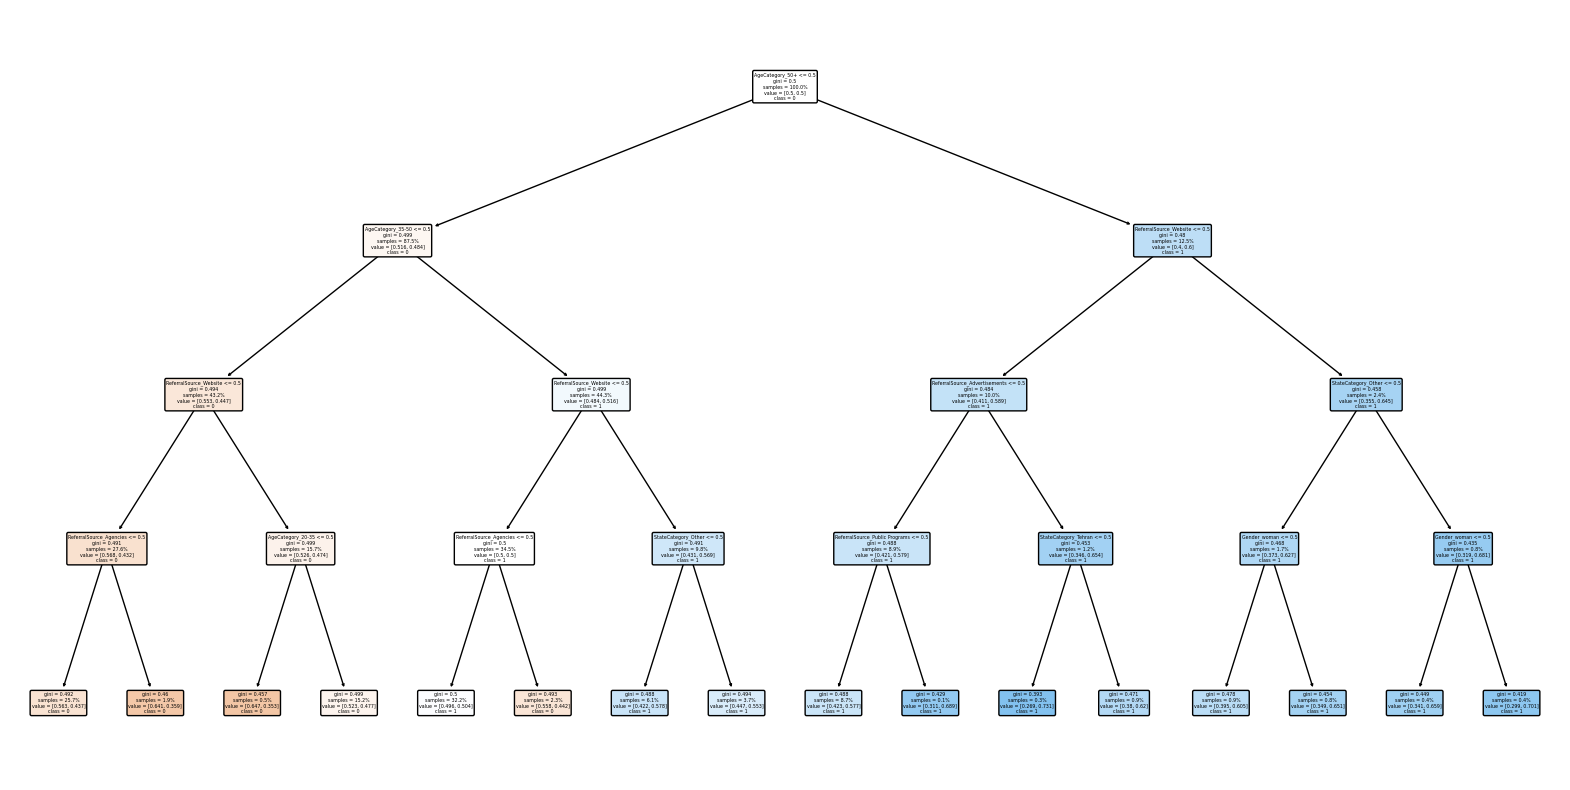

In [63]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(20, 10))

# Plot the tree
plot_tree(best_clf, 
          feature_names=best_clf.feature_names_in_, 
          class_names=[str(cls) for cls in best_clf.classes_], 
          proportion=True,
          filled=True,
          rounded=True)

# Save the figure to a PDF file
plt.savefig("decision_tree.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [64]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94278 entries, 0 to 94277
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   UserID          94278 non-null  int64   
 1   Gender          94278 non-null  object  
 2   ReferralSource  94278 non-null  object  
 3   AgeCategory     94278 non-null  category
 4   StateCategory   94278 non-null  object  
 5   R_Score         94278 non-null  category
 6   F_Score         94278 non-null  category
 7   M_Score         94278 non-null  category
 8   D_Score         94278 non-null  category
 9   cluster         94278 non-null  int32   
 10  silhouette      94278 non-null  float64 
dtypes: category(5), float64(1), int32(1), int64(1), object(3)
memory usage: 4.4+ MB


# statistical hypothesis testing

In [65]:
import pandas as pd

# Assuming merged_data is already defined
# Create a new column 'cluster_merged' that combines classes 0, 1, 2, and 4 into a new group, and keeps class 3
merged_data['cluster_merged'] = merged_data['cluster'].apply(lambda x: "best" if x == 3 else 'Other')



In [66]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data['Gender'], merged_data['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged  Other   best
Gender                      
man             40673  11319
woman           32840   9446

############################################################

Row Percentages:


cluster_merged      Other       best
Gender                              
man             78.229343  21.770657
woman           77.661637  22.338363

############################################################
expected values:



0             1
0  40540.612826  11451.387174
1  32972.387174   9313.612826

Chi-squared value:
4.343171684964159
P-value: 0.03715764267266116
Degrees of freedom: 1
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged       Other        best
Gender                                
man             132.387174 -132.387174
woman          -132.387174  132.387174

############################################################





### ** Chi-Square Test Results**
- **Chi-squared value**: ~4.943
- **p-value**: ~0.037
- **Degrees of freedom (df)**: 1

The p-value is less than the common significance level of 0.05, indicating that there is a statistically significant association between gender and cluster membership at this level.

### ** Residuals (Observed - Expected)**
The residuals measure the difference between observed and expected counts:
- Men: +132.38 for "Other," -132.38 for "best."
- Women: -132.38 for "Other," +132.38 for "best."

These residuals suggest that men are slightly overrepresented in the "Other" cluster and underrepresented in the "best" cluster, while women show the opposite pattern.

### **Interpretation**
There is a small but statistically significant relationship between gender and cluster membership. While both genders follow similar overall patterns, women are slightly more likely to belong to the "best" cluster than men, as indicated by both row percentages and residuals.

This insight could inform targeted marketing strategies or customer engagement efforts based on gender-specific preferences or behaviors within these clusters.



In [67]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data['AgeCategory'], merged_data['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged  Other  best
AgeCategory                
0-20             1396   222
20-35           31696  7325
35-50           32175  9757
50+              8246  3461

############################################################

Row Percentages:


cluster_merged      Other       best
AgeCategory                         
0-20            86.279357  13.720643
20-35           81.228057  18.771943
35-50           76.731375  23.268625
50+             70.436491  29.563509

############################################################
expected values:



0            1
0   1261.630858   356.369142
1  30426.512792  8594.487208
2  32696.356690  9235.643310
3   9128.499661  2578.500339

Chi-squared value:
730.5551742953032
P-value: 4.969576345995638e-158
Degrees of freedom: 3
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged        Other         best
AgeCategory                             
0-20             134.369142  -134.369142
20-35           1269.487208 -1269.487208
35-50           -521.356690   521.356690
50+             -882.499661   882.499661

############################################################


In [68]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data['StateCategory'], merged_data['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged  Other   best
StateCategory               
Alborz           3786    984
Other           21066   5768
Tehran          48661  14013

############################################################

Row Percentages:


cluster_merged      Other       best
StateCategory                       
Alborz          79.371069  20.628931
Other           78.504882  21.495118
Tehran          77.641446  22.358554

############################################################
expected values:



0             1
0   3719.393814   1050.606186
1  20923.734509   5910.265491
2  48869.871677  13804.128323

Chi-squared value:
13.860402243775479
P-value: 0.00097780419079328
Degrees of freedom: 2
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged       Other        best
StateCategory                         
Alborz           66.606186  -66.606186
Other           142.265491 -142.265491
Tehran         -208.871677  208.871677

############################################################


In [69]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data['ReferralSource'], merged_data['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged   Other  best
ReferralSource              
Acquaintances     5575  1366
Advertisements    4747  1522
Agencies          4277   993
Application      18577  4774
Public Programs    613   168
SMS                 77    27
Unknown          19541  5645
Website          20106  6270

############################################################

Row Percentages:


cluster_merged       Other       best
ReferralSource                       
Acquaintances    80.319839  19.680161
Advertisements   75.721806  24.278194
Agencies         81.157495  18.842505
Application      79.555479  20.444521
Public Programs  78.489117  21.510883
SMS              74.038462  25.961538
Unknown          77.586755  22.413245
Website          76.228389  23.771611

############################################################
expected values:



0            1
0   5412.224835  1528.775165
1   4888.234763  1380.765237
2   4109.267379  1160.732621
3  18207.875252  5143.124748
4    608.982509   172.017491
5     81.093702    22.906298
6  19638.711237  5547.288763
7  20566.610323  5809.389677

Chi-squared value:
155.91664192782562
P-value: 2.318361102937574e-30
Degrees of freedom: 7
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged        Other        best
ReferralSource                         
Acquaintances    162.775165 -162.775165
Advertisements  -141.234763  141.234763
Agencies         167.732621 -167.732621
Application      369.124748 -369.124748
Public Programs    4.017491   -4.017491
SMS               -4.093702    4.093702
Unknown          -97.711237   97.711237
Website         -460.610323  460.610323

############################################################


# 8 clusters

In [70]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Initialize the KMeans model
km_model = KMeans(n_clusters=8, init='k-means++', n_init='auto', max_iter=300,
                  tol=0.0001, random_state=111, algorithm='lloyd')

# Fit the model
km_model.fit(X)

# Predict the cluster labels
labels = km_model.predict(X)

# Compute the silhouette score
silhouette_avg = silhouette_score(X, labels)
silhouette = silhouette_samples(X, labels)

print(f'Silhouette Score: {silhouette_avg}')

X_kmeans = X.copy()
X_kmeans['cluster'] = labels
X_kmeans['silhouette'] = silhouette

Silhouette Score: 0.3402823535213844


In [71]:
wss = km_model.inertia_
print('WSS: ', wss)
km_model.cluster_centers_

WSS:  147709.08025556454


array([[4.12585216, 2.34369973, 1.34216775, 3.00551513],
       [1.90578214, 2.23094132, 1.26862846, 2.39975908],
       [4.67935872, 4.61051515, 3.96027349, 4.79924555],
       [1.46861975, 1.        , 1.43026276, 1.        ],
       [2.17564466, 2.6090185 , 3.54948022, 3.07074389],
       [4.26487978, 2.5620812 , 3.55419787, 4.37314413],
       [3.79207743, 1.        , 1.42615164, 1.        ],
       [4.43436995, 4.03140145, 1.63105816, 4.29907108]])

The **WSS (Within-Cluster Sum of Squares)** should ideally be **as low as possible**. A lower WSS indicates that the data points within each cluster are closer to their respective cluster centroids, meaning the clusters are more compact and cohesive.

However, WSS alone is not sufficient to evaluate clustering quality. It tends to decrease as the number of clusters increases, which can lead to overfitting. Therefore, it is often used alongside metrics like the **silhouette score** or methods like the **elbow method** to balance compactness and meaningful clustering.



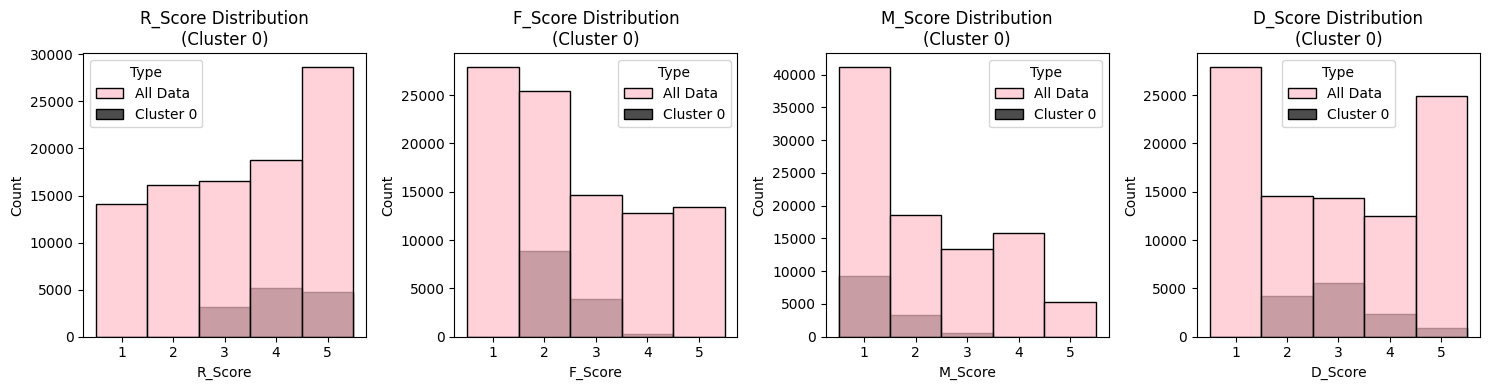

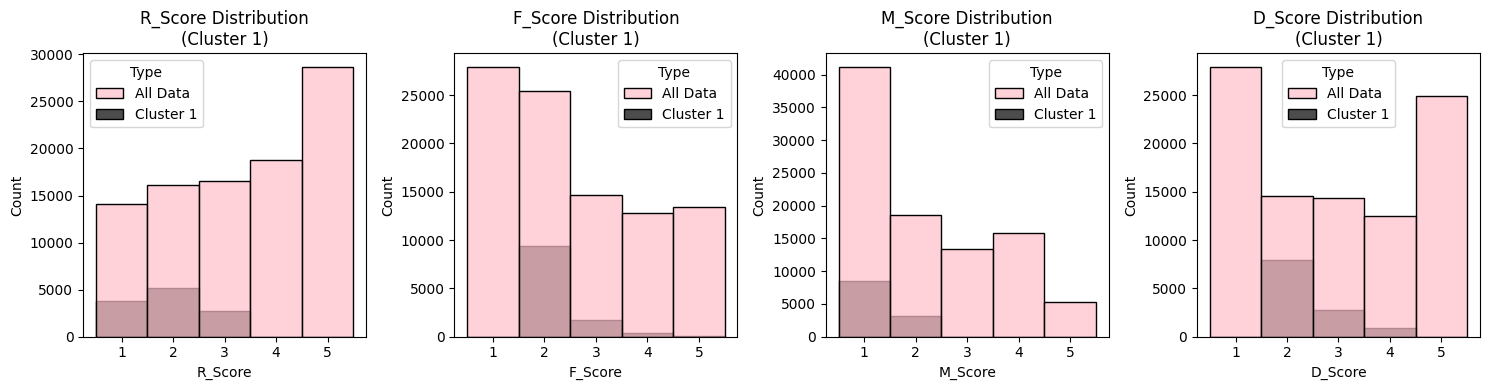

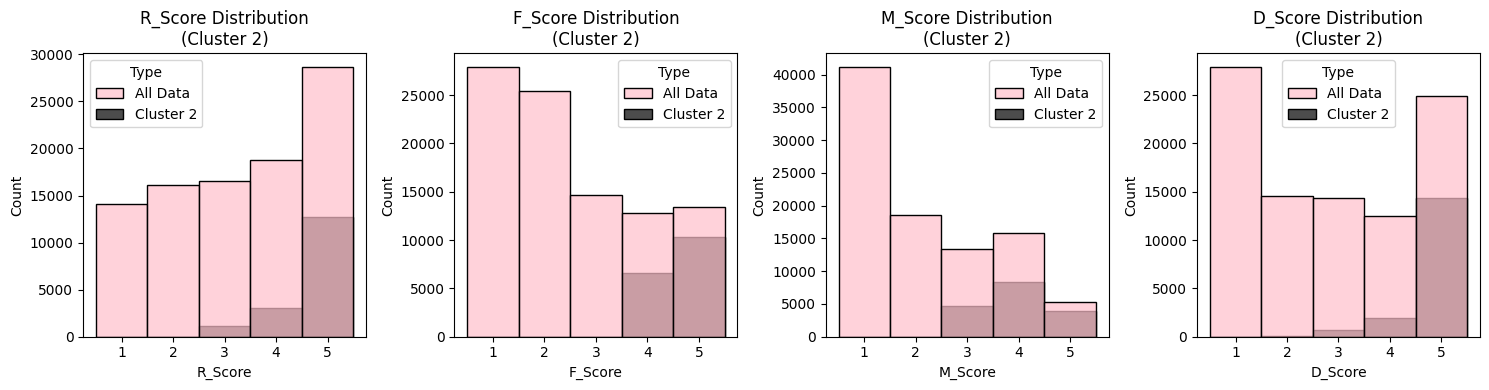

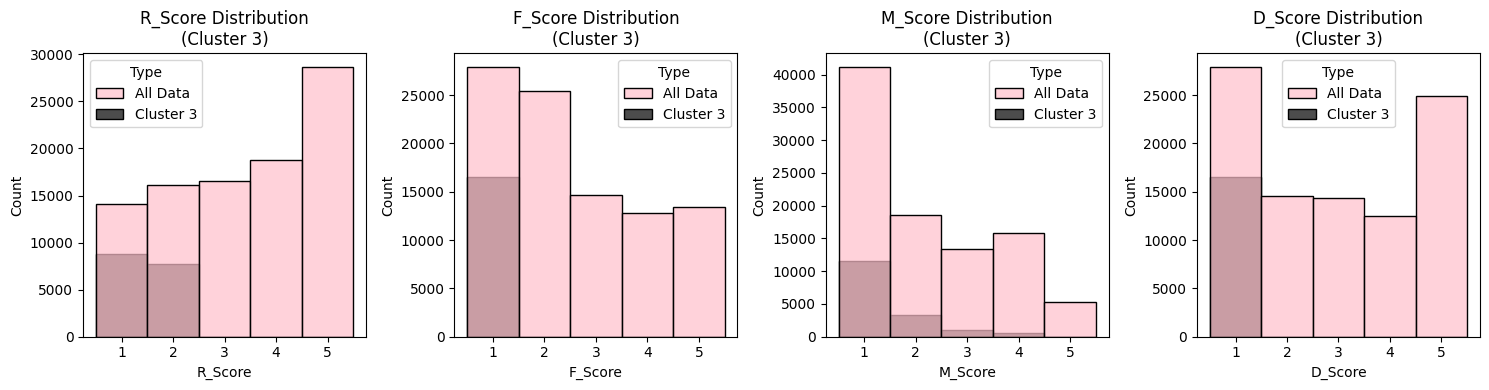

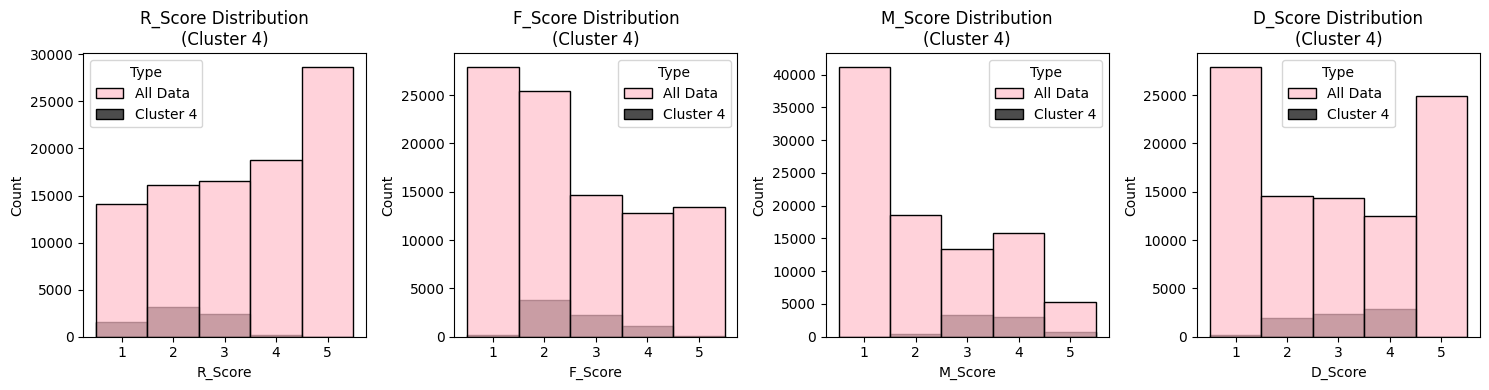

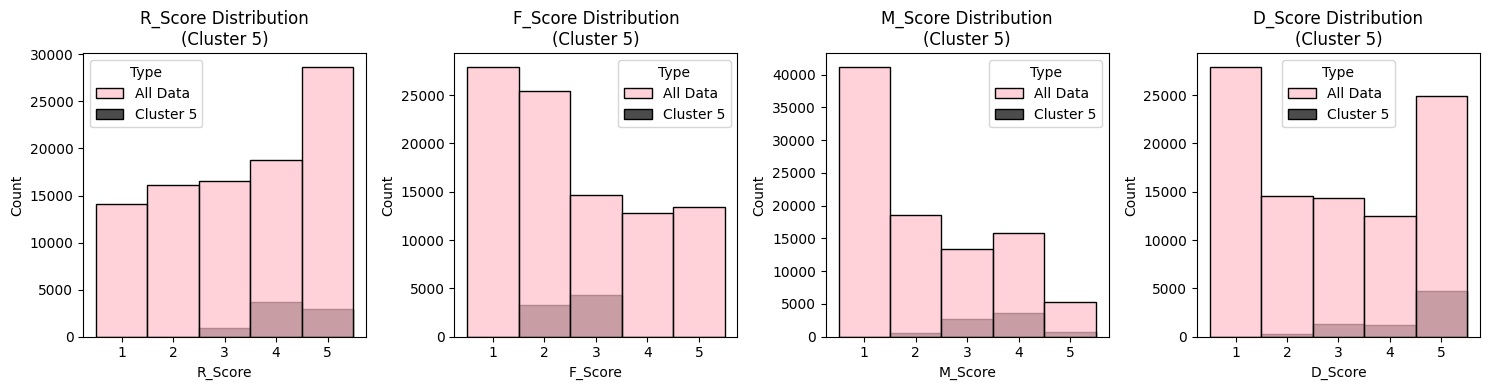

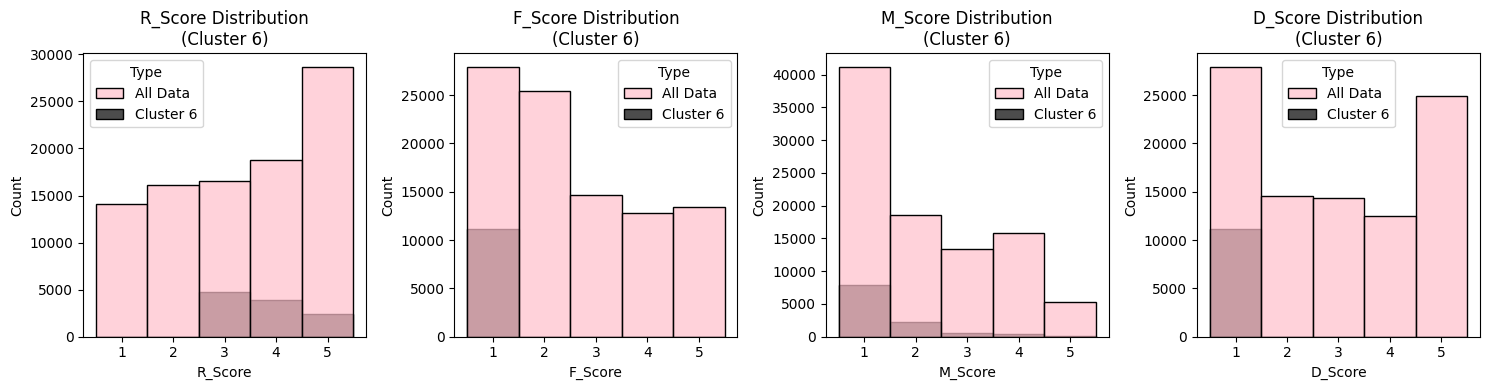

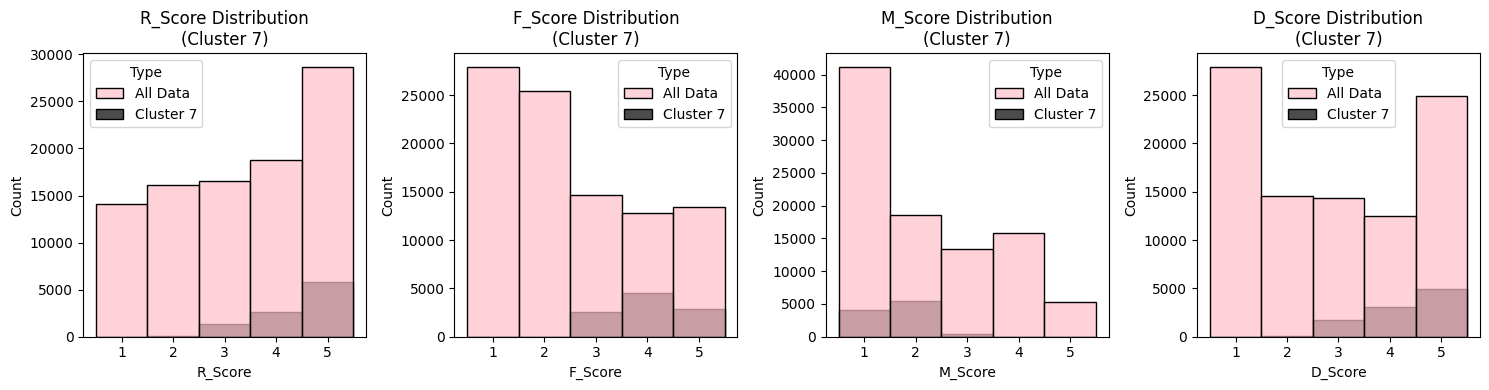

In [72]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress specific warnings
warnings.filterwarnings("ignore")

# Define the scores and clusters
scores = ['R_Score', 'F_Score', 'M_Score', 'D_Score']
clusters = sorted(X_kmeans['cluster'].unique())

# Loop over each cluster
for cluster in clusters:
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, len(scores), figsize=(15, 4))
    
    # Loop over each score and create a count plot
    for i, score in enumerate(scores):
        ax = axes[i]

        # Combine the all data and cluster data into one DataFrame for plotting
        all_data = pd.DataFrame({score: X_kmeans[score], 'Type': 'All Data'})
        data_cluster = pd.DataFrame({score: X_kmeans[X_kmeans['cluster'] == cluster][score], 'Type': f'Cluster {cluster}'})
        data_combined = pd.concat([all_data, data_cluster])

        # Plot the count plot for the combined data
#       sns.countplot(x=score, hue='Type', data=data_combined, ax=ax, palette=['darkred', 'pink'])
        sns.histplot(x=score, hue='Type', data=data_combined, ax=ax, palette=['pink', 'black'], bins=10, kde=False, stat='count', alpha=0.7)
        
        # Set the title and labels
        ax.set_title(f'{score} Distribution\n(Cluster {cluster})')
        ax.set_xlabel(score)
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()


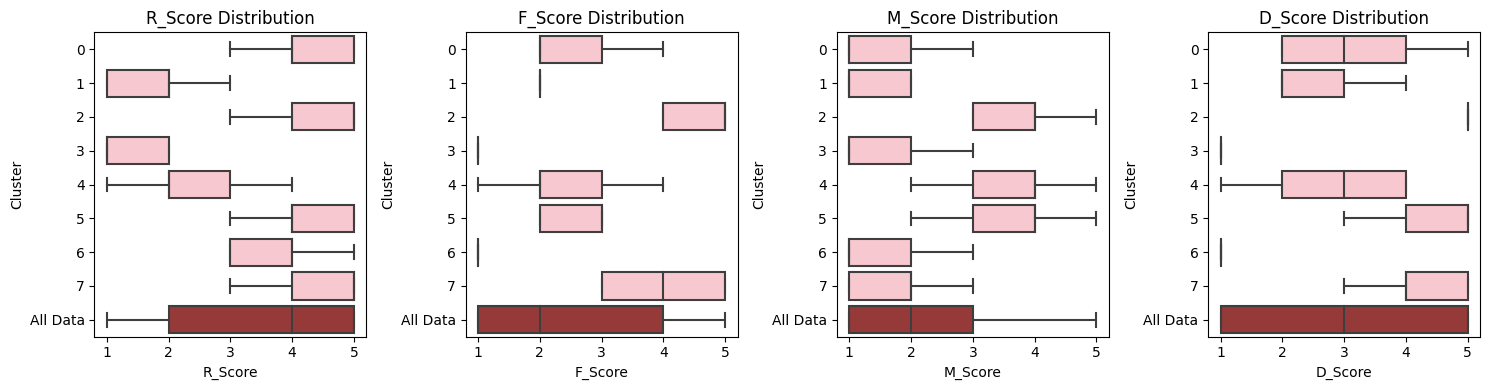

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

scores = ['R_Score', 'F_Score', 'M_Score', 'D_Score']

# Set up the matplotlib figure
fig, axes = plt.subplots(1, len(scores), figsize=(15, 4))

# Define the colors
pink_color = 'pink'  
dark_pink_color = 'brown'  

# Loop over each score and create a horizontal box plot
for i, score in enumerate(scores):
    ax = axes[i]    
    
    # Create a DataFrame for all data
    df_all_data = X_kmeans[[score]].copy()
    df_all_data['cluster'] = 'All Data'

    # Combine the all data DataFrame with the original DataFrame
    combined_df = pd.concat([X_kmeans[['cluster', score]], df_all_data], ignore_index=True)

    # Sort the clusters including 'All Data'
    combined_df['cluster'] = pd.Categorical(combined_df['cluster'], categories= clusters + ['All Data'], ordered=True)
    
    ### Convert the score column to numeric ###
    
    combined_df[score] = combined_df[score].astype(int)
    # Create a horizontal box plot
    sns.boxplot(y='cluster', x=score, data=combined_df, palette= [pink_color] * len(clusters) + [dark_pink_color], ax=ax, showfliers=False)

    # Set the title and labels
    ax.set_title(f'{score} Distribution')
    ax.set_xlabel(score)
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()


In [74]:
import pandas as pd


# Create a copy of X_kmeans
X_kmeans_copy = X_kmeans.copy()

# Convert specified columns to integer type
columns_to_convert = ['R_Score', 'F_Score', 'M_Score', 'D_Score']
X_kmeans_copy[columns_to_convert] = X_kmeans_copy[columns_to_convert].astype(int)



# Group by cluster and calculate the mean for each score

cluster_summary = X_kmeans_copy.groupby('cluster').mean().reset_index()

# Calculate the number of records and percentage for each cluster
cluster_counts = X_kmeans['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']
cluster_counts['percentage'] = (cluster_counts['count'] / len(X_kmeans_copy)) * 100

# Calculate the overall mean for each score
overall_mean = X_kmeans_copy[['R_Score', 'F_Score', 'M_Score', 'D_Score', 'silhouette']].mean().to_frame().T
overall_mean['cluster'] = 'All Data'
overall_mean['count'] = len(X_kmeans_copy)
overall_mean['percentage'] = 100.0

# Rename columns to indicate they are mean values
cluster_summary.columns = ['cluster', 'mean_Recency_Score', 'mean_Frequency_Score', 'mean_Monetary_Score','mean_D_Score', 'mean_Silhouette']

# Merge cluster_summary with cluster_counts
cluster_summary = pd.merge(cluster_summary, cluster_counts, on='cluster')

# Append the overall mean to the cluster summary
overall_mean.columns = ['mean_Recency_Score', 'mean_Frequency_Score', 'mean_Monetary_Score','mean_D_Score', 'mean_Silhouette', 'cluster', 'count', 'percentage']
cluster_summary = pd.concat([cluster_summary, overall_mean], ignore_index=True)

cluster_summary

cluster  mean_Recency_Score  mean_Frequency_Score  mean_Monetary_Score  \
0         0            4.125852              2.343700             1.342168   
1         1            1.905782              2.230941             1.268628   
2         2            4.679359              4.610515             3.960273   
3         3            1.468620              1.000000             1.430263   
4         4            2.175645              2.609018             3.549480   
5         5            4.264880              2.562081             3.554198   
6         6            3.792077              1.000000             1.426152   
7         7            4.434370              4.031401             1.631058   
8  All Data            3.336091              2.558518             2.212001   

   mean_D_Score  mean_Silhouette  count  percentage  
0      3.005515         0.173606  13055   13.847345  
1      2.399759         0.270783  11622   12.327372  
2      4.799246         0.418439  16966   17.995715  
3      1.000000         0.556611  16555   17.559770  
4      3.070744         0.175416   7407    7.856552  
5      4.373144         0.224106   7611    8.072933  
6      1.000000         0.450883  11158   11.835211  
7      4.299071         0.234027   9904   10.505102  
8      2.915537         0.340282  94278  100.000000





### **. Mean Recency, Frequency, Monetary, and D Scores**
These scores represent the characteristics of each cluster:
- **First clustering :**
  - Clusters show distinct differences in recency (e.g., cluster 0 has a mean recency score of 0, while cluster 3 has 4.68).
  - Cluster 3 has the highest monetary score (3.89), indicating it contains high-value customers.
  - Cluster 1 has the lowest frequency score (1.29), suggesting infrequent interactions.

- **Second clustering :**
  - The clusters are more nuanced. For example, cluster 2 has a very high recency score (4.67) and monetary score (3.96), indicating high-value but recent customers.
  - Cluster 3 stands out with low scores across all metrics, representing inactive or low-value customers.
  - Cluster 5 and cluster 7 have high monetary scores (3.55 and 1.63, respectively) but differ in frequency and recency.

**Interpretation:** The second clustering provides a more detailed segmentation of customer behavior, potentially allowing for more targeted strategies.

---

### **. Silhouette Scores**
The silhouette score measures how well-separated each cluster is:
- **First clustering:**
  - Silhouette scores range from 0.17 to 0.45, with an overall average of 0.34.
  - Cluster 0 has the highest silhouette score (1.78), indicating strong separation from other clusters.

- **Second clustering:**
  - Silhouette scores range from 0.17 to 0.55, with an overall average of 0.34.
  - Cluster 3 has the highest silhouette score (0.56), suggesting it is well-defined.

**Interpretation:** The second clustering appears to have slightly better-defined clusters overall, as indicated by higher silhouette scores for some clusters.

---




### **. Overall Comparison**
| Aspect                  | First clustering(5)                      | Second clustering(8)                     |
|-------------------------|-------------------------------------|-------------------------------------|
| Number of Clusters      | Fewer clusters (5)                 | More clusters (8)                  |
| Granularity             | Broader segmentation               | More detailed segmentation          |
| Silhouette Scores       | Lower for most clusters            | Higher for some clusters            |
| Distribution            | One dominant cluster               | More balanced distribution          |

---

### **Conclusion**
The second clustering approach provides a more detailed segmentation with a higher number of clusters and slightly better-defined groups based on silhouette scores. This may allow for more targeted insights and strategies but could also introduce complexity in interpretation and actionability.

The choice between these two approaches depends on your goals:
- Use the first clustering if you prefer simpler segmentation with fewer groups.
- Use the second clustering if you need finer distinctions between customer groups for targeted strategies.

In [75]:
cluster_name = {
    '2': 'High-Value',
    '5': 'Potential Loyal',
    '7': 'Frequent Segment',
    '4': 'Mid Engagement',
    '0': 'Low Engagement',
    '1': 'Inactive',
    '6': 'Occasional Buyers',
    '3': 'Least Engaged'
}
cluster_summary['cluster'] = cluster_summary['cluster'].astype(str).replace(cluster_name)

rfm_weights = {'R': 1,
              'F': 1,
              'M': 1,
              'D': 1}

cluster_summary['CLV'] = (cluster_summary['mean_Recency_Score'] * rfm_weights['R'] + 
                          cluster_summary['mean_Frequency_Score'] * rfm_weights['F'] + 
                          cluster_summary['mean_Monetary_Score'] * rfm_weights['M'] +
                          cluster_summary['mean_D_Score'] * rfm_weights['D'])
        
cluster_summary.sort_values(by='CLV', ascending=False)

cluster  mean_Recency_Score  mean_Frequency_Score  \
2         High-Value            4.679359              4.610515   
5    Potential Loyal            4.264880              2.562081   
7   Frequent Segment            4.434370              4.031401   
4     Mid Engagement            2.175645              2.609018   
8           All Data            3.336091              2.558518   
0     Low Engagement            4.125852              2.343700   
1           Inactive            1.905782              2.230941   
6  Occasional Buyers            3.792077              1.000000   
3      Least Engaged            1.468620              1.000000   

   mean_Monetary_Score  mean_D_Score  mean_Silhouette  count  percentage  \
2             3.960273      4.799246         0.418439  16966   17.995715   
5             3.554198      4.373144         0.224106   7611    8.072933   
7             1.631058      4.299071         0.234027   9904   10.505102   
4             3.549480      3.070744         0.175416   7407    7.856552   
8             2.212001      2.915537         0.340282  94278  100.000000   
0             1.342168      3.005515         0.173606  13055   13.847345   
1             1.268628      2.399759         0.270783  11622   12.327372   
6             1.426152      1.000000         0.450883  11158   11.835211   
3             1.430263      1.000000         0.556611  16555   17.559770   

         CLV  
2  18.049393  
5  14.754303  
7  14.395901  
4  11.404887  
8  11.022147  
0  10.817235  
1   7.805111  
6   7.218229  
3   4.898883

In [76]:
# Updated mapping of cluster labels to cluster names
cluster_name = {
    '2': 'High-Value',
    '5': 'Potential Loyal',
    '7': 'Frequent Segment',
    '4': 'Mid Engagement',
    '0': 'Low Engagement',
    '1': 'Inactive',
    '6': 'Occasional Buyers',
    '3': 'Least Engaged'
}

# Assign the cluster names to a new column based on the cluster label
X_kmeans['Cluster_Name'] = X_kmeans['cluster'].astype(str).replace(cluster_name)

# Check the result
print(X_kmeans[['Cluster_Name']].head())

        Cluster_Name
0     Low Engagement
1  Occasional Buyers
2     Low Engagement
3     Mid Engagement
4      Least Engaged


In [77]:
# Drop the specified columns
df_ben_dropped_8 = df_ben.drop(columns=['BirthDate', 'Age_imp', 'Age', 'Unnamed: 0', 'BirthYear', 'State', "LatestPaymentYear"])
df_ben_dropped_8["Gender"] = df_ben_dropped["Gender"].replace({"زن": "woman", "مرد": "man"})

# Check the result to confirm the columns were dropped
print(df_ben_dropped_8.head())

   UserID Gender ReferralSource AgeCategory StateCategory
0       3  woman  Acquaintances       20-35        Tehran
1       8    man  Acquaintances       20-35        Tehran
2      14    man  Acquaintances       35-50        Tehran
3      17  woman  Acquaintances         50+        Tehran
4      18  woman  Acquaintances         50+        Tehran


In [78]:
X_kmeans_8 = X_kmeans.merge(final_aggregation[['UserID']], left_index=True, right_index=True)

In [79]:
import pandas as pd

# Perform outer joins on common identifiers
merged_data_8 = pd.merge(df_ben_dropped_8, X_kmeans_8, on="UserID", how="inner")

# Display the resulting DataFrame containing all farmers' data
print(merged_data_8)

       UserID Gender ReferralSource AgeCategory StateCategory R_Score F_Score  \
0           3  woman  Acquaintances       20-35        Tehran       3       3   
1          17  woman  Acquaintances         50+        Tehran       5       2   
2          20  woman  Acquaintances         50+        Tehran       3       2   
3          26    man  Acquaintances         50+        Tehran       1       1   
4          29    man  Acquaintances         50+        Tehran       3       2   
...       ...    ...            ...         ...           ...     ...     ...   
94273  262137  woman    Application       20-35         Other       5       4   
94274  262138  woman    Application       20-35         Other       4       2   
94275  262139    man    Application       35-50        Tehran       5       3   
94276  262140    man    Application       35-50        Tehran       5       4   
94277  262141    man    Application       20-35         Other       4       3   

      M_Score D_Score  clus

In [80]:
# Save the dataset to a CSV file
merged_data_8.to_csv('merged_data_backup_8.csv', index=False)

In [81]:
# Separate the target column
target_8 = merged_data_8['Cluster_Name']

# Drop the target column from the DataFrame
merged_data_8 = merged_data_8.drop(columns=['Cluster_Name'])

In [82]:
from sklearn.preprocessing import StandardScaler

# Create a copy of merged_data for encoding and scaling
merged_data_encoded_8 = merged_data_8.copy()

# List of columns to one-hot encode
categorical_columns = ['Gender', 'ReferralSource', 'StateCategory','AgeCategory']

# Apply one-hot encoding to the copied DataFrame
merged_data_encoded_8 = pd.get_dummies(merged_data_encoded_8, columns=categorical_columns, drop_first=True)



# Check the resulting DataFrame
merged_data_encoded_8

UserID R_Score F_Score M_Score D_Score  cluster  silhouette  \
0           3       3       3       1       4        0    0.110514   
1          17       5       2       2       5        5    0.110321   
2          20       3       2       3       3        4    0.224468   
3          26       1       1       4       1        3    0.161992   
4          29       3       2       3       4        4   -0.004136   
...       ...     ...     ...     ...     ...      ...         ...   
94273  262137       5       4       1       3        7    0.133645   
94274  262138       4       2       1       3        0    0.430992   
94275  262139       5       3       2       2        0    0.282237   
94276  262140       5       4       1       3        7    0.133645   
94277  262141       4       3       1       3        0    0.334656   

       Gender_woman  ReferralSource_Advertisements  ReferralSource_Agencies  \
0              True                          False                    False   
1              True                          False                    False   
2              True                          False                    False   
3             False                          False                    False   
4             False                          False                    False   
...             ...                            ...                      ...   
94273          True                          False                    False   
94274          True                          False                    False   
94275         False                          False                    False   
94276         False                          False                    False   
94277         False                          False                    False   

       ReferralSource_Application  ReferralSource_Public Programs  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   
...                           ...                             ...   
94273                        True                           False   
94274                        True                           False   
94275                        True                           False   
94276                        True                           False   
94277                        True                           False   

       ReferralSource_SMS  ReferralSource_Unknown  ReferralSource_Website  \
0                   False                   False                   False   
1                   False                   False                   False   
2                   False                   False                   False   
3                   False                   False                   False   
4                   False                   False                   False   
...                   ...                     ...                     ...   
94273               False                   False                   False   
94274               False                   False                   False   
94275               False                   False                   False   
94276               False                   False                   False   
94277               False                   False                   False   

       StateCategory_Other  StateCategory_Tehran  AgeCategory_20-35  \
0                    False                  True               True   
1                    False                  True              False   
2                    False                  True              False   
3                    False                  True              False   
4                    False                  True              False   
...                    ...           

In [83]:
# Convert the target to binary: 1 for 'best', 0 for others
target_binary_8 = target_8.map(lambda x: 1 if x.strip().lower() == 'high-value' else 0)

# Display the first few rows of the new binary target
print(target_binary_8.head())

0    0
1    0
2    0
3    0
4    0
Name: Cluster_Name, dtype: int64


In [84]:
target_binary_8.value_counts()

Cluster_Name
0    77312
1    16966
Name: count, dtype: int64

In [85]:
from sklearn.model_selection import train_test_split
# to drop ['UserID','silhouette','cluster','R_Score','F_Score','M_Score','D_Score' ]
merged_data_encoded_8 = merged_data_encoded_8.drop(columns=['UserID','silhouette','cluster','R_Score','F_Score','M_Score','D_Score' ])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_data_encoded_8, target_binary_8, test_size=0.3, random_state=3)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (65994, 13)
X_test shape: (28284, 13)
y_train shape: (65994,)
y_test shape: (28284,)


In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Define a custom scorer for class '1' F1-score
custom_scorer = make_scorer(f1_score, labels=[1], average='binary')

# Define the parameter grid
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [ 3, 4, 5 ],
    'min_samples_split': [ 40,50, 60, 80, 100],
    'min_samples_leaf': [ 30,40, 60, 80, 100],
    'class_weight': [None, 'balanced']
}


# Instantiate the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=111)

# Instantiate GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=custom_scorer)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Evaluate the best estimator on the test set
accuracy = best_clf.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 40}
Test Accuracy: 0.47468533446471506


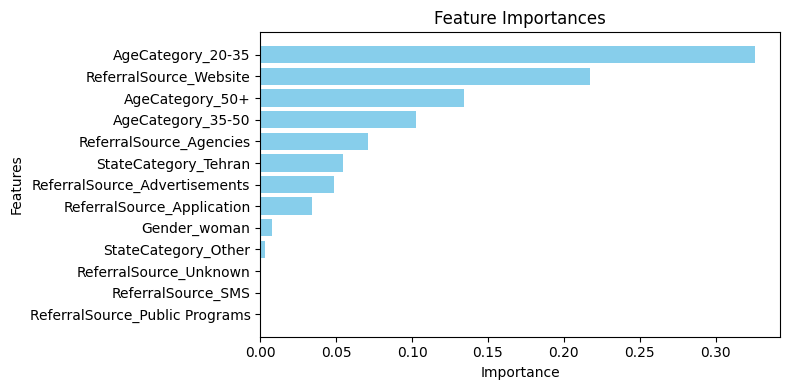

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances and feature names
importances = best_clf.feature_importances_
feature_names = best_clf.feature_names_in_

# Sort feature importances in descending order
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.barh(range(len(feature_names)), importances[indices], color="skyblue", align="center")
plt.yticks(range(len(feature_names)), feature_names[indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [88]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Train the classifier with the full training data
best_clf.fit(X_train, y_train)

# Predict the labels for the train set
y_pred_train = best_clf.predict(X_train)
y_prob_train = best_clf.predict_proba(X_train)

# Confusion Matrix for Training Set
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix for Training Set:")
print(conf_matrix_train)

# Classification Report for Training Set
report_train = classification_report(y_train, y_pred_train, zero_division='warn')
print("Classification Report for Training Set:")
print(report_train)

# ROC AUC Score for Training Set
roc_auc_train = roc_auc_score(y_train, y_prob_train[:, 1])
print("ROC AUC Score for Training Set:", roc_auc_train)
print("#" * 60)

# Predict the labels for the test set
y_pred_test = best_clf.predict(X_test)
y_prob_test = best_clf.predict_proba(X_test)

# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

# Classification Report for Test Set
report_test = classification_report(y_test, y_pred_test, zero_division='warn')
print("Classification Report for Test Set:")
print(report_test)

# ROC AUC Score for Test Set
roc_auc_test = roc_auc_score(y_test, y_prob_test[:, 1])
print("ROC AUC Score for Test Set:", roc_auc_test)


Confusion Matrix for Training Set:
[[23838 30247]
 [ 4322  7587]]
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.85      0.44      0.58     54085
           1       0.20      0.64      0.31     11909

    accuracy                           0.48     65994
   macro avg       0.52      0.54      0.44     65994
weighted avg       0.73      0.48      0.53     65994

ROC AUC Score for Training Set: 0.5596380747897218
############################################################
Confusion Matrix for Test Set:
[[10167 13060]
 [ 1798  3259]]
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.44      0.58     23227
           1       0.20      0.64      0.30      5057

    accuracy                           0.47     28284
   macro avg       0.52      0.54      0.44     28284
weighted avg       0.73      0.47      0.53     28284

ROC AUC Score for Test Set: 0.

In [89]:
feature_names = X_train.columns.tolist()

# Set the maximum column width
pd.set_option('display.max_colwidth', None)

rules = get_rules(best_clf, feature_names, task='class')
rules

Antecedent  \
0                    (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Agencies <= 0.5)   
1   (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran <= 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Advertisements <= 0.5)   
2       (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Application <= 0.5)   
3     (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Application <= 0.5)   
4        (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Application > 0.5)   
5                                (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (Gender_woman <= 0.5)   
6                                                           (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman <= 0.5)   
7                                                            (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman > 0.5)   
8                                 (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (Gender_woman > 0.5)   
9                          (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman <= 0.5) and (StateCategory_Other > 0.5)   
10                          (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman > 0.5) and (StateCategory_Other > 0.5)   
11                    (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Agencies > 0.5)   
12     (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Application > 0.5)   
13            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Advertisements <= 0.5)   
14            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran > 0.5)   
15                             (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman <= 0.5)   
16                      (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies > 0.5) and (Gender_woman > 0.5)   
17                              (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman > 0.5)   
18                     (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies > 0.5) and (Gender_woman <= 0.5)   
19   (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran <= 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Advertisements > 0.5)   
20                            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman <= 0.5)   
21                             (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Teh

In [90]:
calculate_rule_metrics(rules, X_train, y_train, task='class')

Antecedent  \
0                    (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Agencies <= 0.5)   
1   (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran <= 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Advertisements <= 0.5)   
2       (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Application <= 0.5)   
3     (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Application <= 0.5)   
4        (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Application > 0.5)   
5                                (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (Gender_woman <= 0.5)   
6                                                           (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman <= 0.5)   
7                                                            (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman > 0.5)   
8                                 (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (Gender_woman > 0.5)   
9                          (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman <= 0.5) and (StateCategory_Other > 0.5)   
10                          (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman > 0.5) and (StateCategory_Other > 0.5)   
11                    (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Agencies > 0.5)   
12     (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Application > 0.5)   
13            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Advertisements <= 0.5)   
14            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran > 0.5)   
15                             (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman <= 0.5)   
16                      (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies > 0.5) and (Gender_woman > 0.5)   
17                              (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman > 0.5)   
18                     (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies > 0.5) and (Gender_woman <= 0.5)   
19   (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran <= 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Advertisements > 0.5)   
20                            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman <= 0.5)   
21                             (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Teh

In [91]:
calculate_rule_metrics(rules, X_test, y_test, task='class')

Antecedent  \
0                    (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Agencies <= 0.5)   
1   (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran <= 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Advertisements <= 0.5)   
2       (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Application <= 0.5)   
3     (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Application <= 0.5)   
4        (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Application > 0.5)   
5                                (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (Gender_woman <= 0.5)   
6                                                           (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman <= 0.5)   
7                                                            (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman > 0.5)   
8                                 (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (Gender_woman > 0.5)   
9                          (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman <= 0.5) and (StateCategory_Other > 0.5)   
10                          (AgeCategory_20-35 > 0.5) and (ReferralSource_Website > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman > 0.5) and (StateCategory_Other > 0.5)   
11                    (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 > 0.5) and (ReferralSource_Agencies > 0.5)   
12     (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements <= 0.5) and (ReferralSource_Application > 0.5)   
13            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ <= 0.5) and (AgeCategory_35-50 <= 0.5) and (ReferralSource_Advertisements <= 0.5)   
14            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website <= 0.5) and (AgeCategory_50+ > 0.5) and (ReferralSource_Advertisements > 0.5) and (StateCategory_Tehran > 0.5)   
15                             (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman <= 0.5)   
16                      (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies > 0.5) and (Gender_woman > 0.5)   
17                              (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran > 0.5) and (Gender_woman > 0.5)   
18                     (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran > 0.5) and (ReferralSource_Agencies > 0.5) and (Gender_woman <= 0.5)   
19   (AgeCategory_20-35 > 0.5) and (ReferralSource_Website <= 0.5) and (StateCategory_Tehran <= 0.5) and (ReferralSource_Agencies <= 0.5) and (ReferralSource_Advertisements > 0.5)   
20                            (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Tehran <= 0.5) and (Gender_woman <= 0.5)   
21                             (AgeCategory_20-35 <= 0.5) and (ReferralSource_Website > 0.5) and (AgeCategory_50+ > 0.5) and (StateCategory_Teh

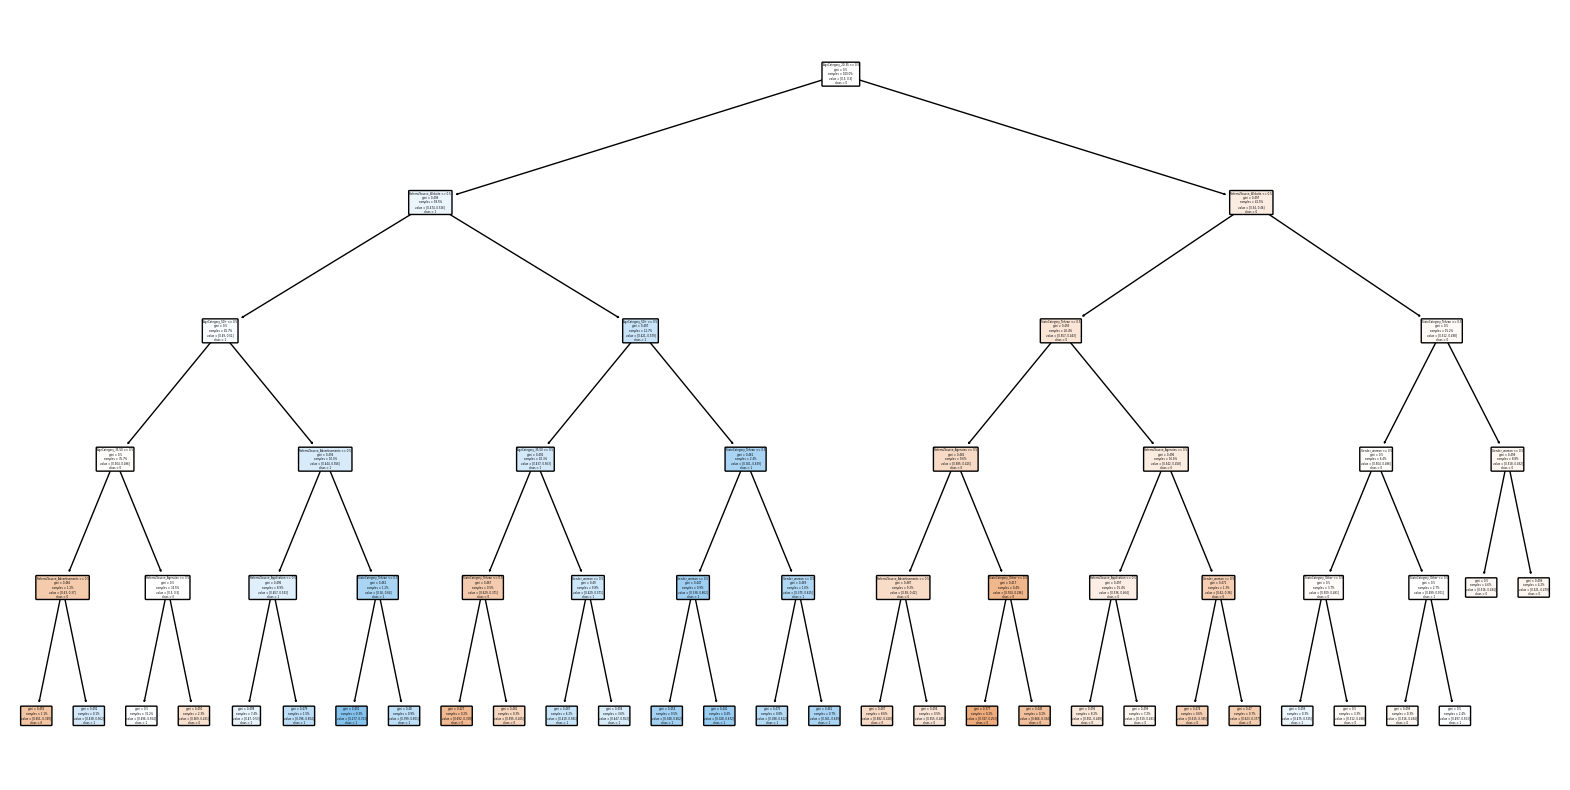

In [92]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(20, 10))

# Plot the tree
plot_tree(best_clf, 
          feature_names=best_clf.feature_names_in_, 
          class_names=[str(cls) for cls in best_clf.classes_], 
          proportion=True,
          filled=True,
          rounded=True)

# Save the figure to a PDF file
plt.savefig("decision_tree_8.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [93]:
import pandas as pd

# Assuming merged_data is already defined
# Create a new column 'cluster_merged' that combines classes 0, 1, 2, and 4 into a new group, and keeps class 3
merged_data_8['cluster_merged'] = merged_data_8['cluster'].apply(lambda x: "best" if x == 2 else 'Other')

# statistical hypothesis testing 8

In [94]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data_8['Gender'], merged_data_8['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged  Other  best
Gender                     
man             42675  9317
woman           34637  7649

############################################################

Row Percentages:


cluster_merged      Other       best
Gender                              
man             82.079935  17.920065
woman           81.911271  18.088729

############################################################
expected values:



0            1
0  42635.667961  9356.332039
1  34676.332039  7609.667961

Chi-squared value:
0.43817942294011525
P-value: 0.508002481755482
Degrees of freedom: 1
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged      Other       best
Gender                              
man             39.332039 -39.332039
woman          -39.332039  39.332039

############################################################


In [95]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data_8['AgeCategory'], merged_data_8['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged  Other  best
AgeCategory                
0-20             1437   181
20-35           32900  6121
35-50           33948  7984
50+              9027  2680

############################################################

Row Percentages:


cluster_merged      Other       best
AgeCategory                         
0-20            88.813350  11.186650
20-35           84.313575  15.686425
35-50           80.959649  19.040351
50+             77.107713  22.892287

############################################################
expected values:



0            1
0   1326.829335   291.170665
1  31998.892128  7022.107872
2  34386.036870  7545.963130
3   9600.241668  2106.758332

Chi-squared value:
413.05686159858294
P-value: 3.287265286841895e-89
Degrees of freedom: 3
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged       Other        best
AgeCategory                           
0-20            110.170665 -110.170665
20-35           901.107872 -901.107872
35-50          -438.036870  438.036870
50+            -573.241668  573.241668

############################################################


### merge the age categories "0-20" and "20-35" into a single category called "0-35" 

In [96]:
import pandas as pd
from scipy.stats import chi2_contingency

# Merge age categories
merged_data_8['AgeCategory'] = merged_data_8['AgeCategory'].replace({'0-20': '0-35', '20-35': '0-35'})

# Create the updated contingency table
contingency_table = pd.crosstab(merged_data_8['AgeCategory'], merged_data_8['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)


Contingency Table with Frequencies:


cluster_merged  Other  best
AgeCategory                
0-35            34337  6302
35-50           33948  7984
50+              9027  2680

############################################################

Row Percentages:


cluster_merged      Other       best
AgeCategory                         
0-35            84.492729  15.507271
35-50           80.959649  19.040351
50+             77.107713  22.892287

############################################################
expected values:



0            1
0  33325.721462  7313.278538
1  34386.036870  7545.963130
2   9600.241668  2106.758332

Chi-squared value:
391.7406579167443
P-value: 8.601951009635493e-86
Degrees of freedom: 2
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged        Other         best
AgeCategory                             
0-35            1011.278538 -1011.278538
35-50           -438.036870   438.036870
50+             -573.241668   573.241668

############################################################


In [97]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data_8['StateCategory'], merged_data_8['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged  Other   best
StateCategory               
Alborz           3967    803
Other           22035   4799
Tehran          51310  11364

############################################################

Row Percentages:


cluster_merged      Other       best
StateCategory                       
Alborz          83.165618  16.834382
Other           82.115972  17.884028
Tehran          81.868079  18.131921

############################################################
expected values:



0             1
0   3911.604404    858.395596
1  22005.029890   4828.970110
2  51395.365706  11278.634294

Chi-squared value:
5.3741244278203055
P-value: 0.06808065226445603
Degrees of freedom: 2
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged      Other       best
StateCategory                       
Alborz          55.395596 -55.395596
Other           29.970110 -29.970110
Tehran         -85.365706  85.365706

############################################################


### try merge "Alborz" and "Other" into a single category

In [98]:
import pandas as pd
from scipy.stats import chi2_contingency

# Define mapping for merging categories
state_mapping = {
    "Alborz": "Merged_Other",
    "Other": "Merged_Other",
    "Tehran": "Tehran"  # Keep Tehran unchanged
}

# Apply the mapping to the 'StateCategory' column
merged_data_8["StateCategory"] = merged_data_8["StateCategory"].replace(state_mapping)

# Create the contingency table again after merging
contingency_table = pd.crosstab(merged_data_8['StateCategory'], merged_data_8['cluster_merged'])

print("Contingency Table with Frequencies (After Merging):")
display(contingency_table)
print("#" * 60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages (After Merging):")
display(row_percentages)
print("#" * 60)

# Perform chi-square test again
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Expected Values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared Value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("#" * 60)

# Calculate residuals (observed - expected)
residuals = contingency_table - expected

print("\nResiduals (After Merging):")
display(residuals)
print("#" * 60)


Contingency Table with Frequencies (After Merging):


cluster_merged  Other   best
StateCategory               
Merged_Other    26002   5602
Tehran          51310  11364

############################################################

Row Percentages (After Merging):


cluster_merged      Other       best
StateCategory                       
Merged_Other    82.274396  17.725604
Tehran          81.868079  18.131921

############################################################
Expected Values:



0             1
0  25916.634294   5687.365706
1  51395.365706  11278.634294

Chi-squared Value:
2.3229491282722106
P-value: 0.12747813493381496
Degrees of Freedom: 1
############################################################

Residuals (After Merging):


cluster_merged      Other       best
StateCategory                       
Merged_Other    85.365706 -85.365706
Tehran         -85.365706  85.365706

############################################################


In [99]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create the contingency table
contingency_table = pd.crosstab(merged_data_8['ReferralSource'], merged_data_8['cluster_merged'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("#"*60) 

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"expected values:\n")
display(pd.DataFrame(expected))
print(f"Chi-squared value:\n{chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("#"*60)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100

print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("#"*60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nResiduals (Observed - Expected):")
display(residuals)
print("#"*60)

Contingency Table with Frequencies:


cluster_merged   Other  best
ReferralSource              
Acquaintances     5872  1069
Advertisements    5029  1240
Agencies          4532   738
Application      19262  4089
Public Programs    650   131
SMS                 83    21
Unknown          20749  4437
Website          21135  5241

############################################################

Row Percentages:


cluster_merged       Other       best
ReferralSource                       
Acquaintances    84.598761  15.401239
Advertisements   80.220131  19.779869
Agencies         85.996205  14.003795
Application      82.488973  17.511027
Public Programs  83.226633  16.773367
SMS              79.807692  20.192308
Unknown          82.383070  17.616930
Website          80.129663  19.870337

############################################################
expected values:



0            1
0   5691.917436  1249.082564
1   5140.848639  1128.151361
2   4321.625830   948.374170
3  19148.820637  4202.179363
4    640.453467   140.546533
5     85.284457    18.715543
6  20653.599270  4532.400730
7  21629.450264  4746.549736

Chi-squared value:
172.19726408756154
P-value: 8.637718888395743e-34
Degrees of freedom: 7
############################################################
Percentage of cells with expected counts less than 5: 0.00%
############################################################

Residuals (Observed - Expected):


cluster_merged        Other        best
ReferralSource                         
Acquaintances    180.082564 -180.082564
Advertisements  -111.848639  111.848639
Agencies         210.374170 -210.374170
Application      113.179363 -113.179363
Public Programs    9.546533   -9.546533
SMS               -2.284457    2.284457
Unknown           95.400730  -95.400730
Website         -494.450264  494.450264

############################################################


Updated Contingency Table with Frequencies:


cluster_merged         Other  best
ReferralSource                    
Digital Sources         5112  1261
Institutional Sources  40661  8657
Personal Sources       10404  1807
Website                21135  5241

############################################################

Updated Row Percentages:


cluster_merged             Other       best
ReferralSource                             
Digital Sources        80.213400  19.786600
Institutional Sources  82.446571  17.553429
Personal Sources       85.201867  14.798133
Website                80.129663  19.870337

############################################################
Updated Expected Values:



0            1
0   5226.133096  1146.866904
1  40442.873374  8875.126626
2  10013.543266  2197.456734
3  21629.450264  4746.549736

Updated Chi-Squared Value:
167.80206801360998
Updated P-Value: 3.7944427836855486e-36
Updated Degrees of Freedom: 3
############################################################

Updated Residuals (Observed - Expected):


cluster_merged              Other        best
ReferralSource                               
Digital Sources       -114.133096  114.133096
Institutional Sources  218.126626 -218.126626
Personal Sources       390.456734 -390.456734
Website               -494.450264  494.450264

############################################################


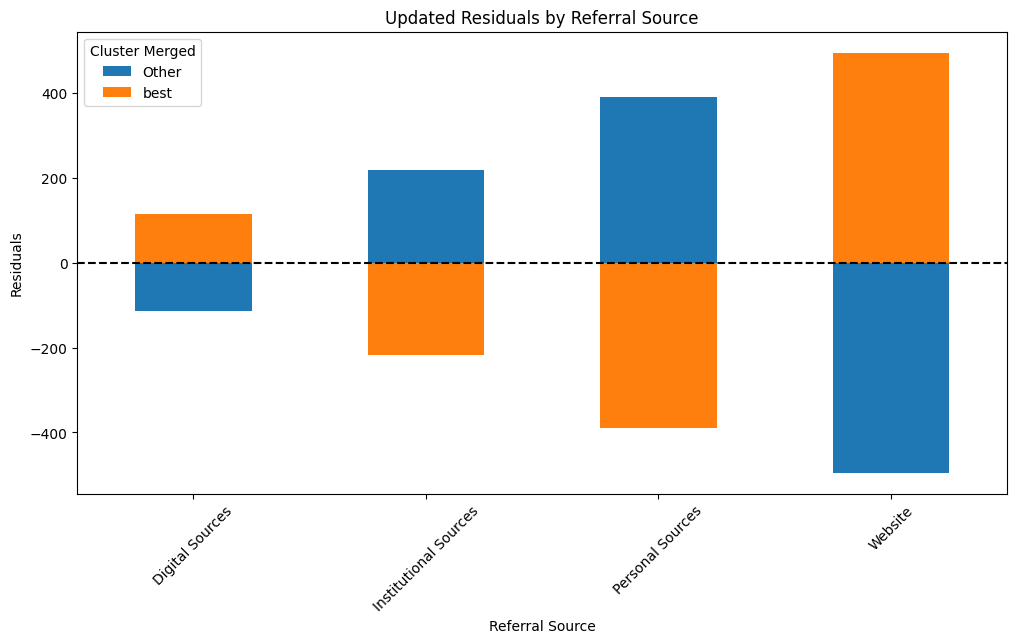

In [100]:
import pandas as pd

# Merge groups into specified broader categories
merged_data_8['ReferralSource'] = merged_data_8['ReferralSource'].replace({
    'Advertisements': 'Digital Sources',
    'SMS': 'Digital Sources',
    'Acquaintances': 'Personal Sources',
    'Agencies': 'Personal Sources',
    'Application': 'Institutional Sources',
    'Unknown': 'Institutional Sources',
    'Public Programs': 'Institutional Sources'
})

# Create the updated contingency table
contingency_table = pd.crosstab(merged_data_8['ReferralSource'], merged_data_8['cluster_merged'])

print("Updated Contingency Table with Frequencies:")
display(contingency_table)
print("#" * 60)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nUpdated Row Percentages:")
display(row_percentages)
print("#" * 60)

# Perform Chi-Square test on the updated table
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Updated Expected Values:\n")
display(pd.DataFrame(expected))
print(f"Updated Chi-Squared Value:\n{chi2}")
print(f"Updated P-Value: {p}")
print(f"Updated Degrees of Freedom: {dof}")
print("#" * 60)

# Calculate residuals (observed minus expected values)
residuals = contingency_table - expected

print("\nUpdated Residuals (Observed - Expected):")
display(residuals)
print("#" * 60)

# Plot the updated residuals
import matplotlib.pyplot as plt

residuals.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.axhline(0, color='black', linestyle='--')
plt.title('Updated Residuals by Referral Source')
plt.ylabel('Residuals')
plt.xlabel('Referral Source')
plt.legend(title='Cluster Merged')
plt.xticks(rotation=45)
plt.show()
